# Landing Rating System



## Imports libraries

In [1]:
import os

# Dataframe and Mathematical Toolbox
import pandas as pd
import numpy as np
import datetime as dt
from scipy.signal import find_peaks

# Visualization Packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 120)

## Tacview csv flight data

In [2]:
# Tacview Data Parameters
sampling_rate = 10 # Hz

# Input directory
input_path= r"C:\Users\Fardad\Desktop\Landing Rating\Datasets\Tacview-20250831-211257-DCS-Client-IQT-1 Checkride 1.csv"

# Read csv file
df = pd.read_csv(input_path)
# Get date from tacview file
date_tacview = pd.to_datetime(df.loc[0,'ISO time'], errors='coerce').strftime('%Y.%m.%d')

# Make Output directory
results_dir = fr'..\Landing Rating\Results\[{date_tacview}] IQT-1 Exam'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(results_dir+'\\Detailed Touchdowns', exist_ok=True)

df.head(2)

ISO time     Unix time   Id   Longitude   Latitude  Altitude  \
0  2020-05-31T20:41...  1.590958e+09  102  145.198777  14.864808   6096.00   
1  2020-05-31T20:41...  1.590958e+09  103  144.918735  13.586413    159.48   

   Roll  Pitch    Yaw         U          V  Heading      Name  \
0   0.0    4.7  270.3  44624.05  152314.84    270.7    KC-135   
1  -0.3    0.7  155.9  13220.07   11107.55    156.4  F-16C_50   

              Pilot         CAS          AGL  VS  
0        Aerial-3-1  135.447556  6096.000000 NaN  
1  < 404C > Phoenix    0.000000     1.811981 NaN

## Filter to Pilots List

In [3]:
# # Choose Pilots to be evaluated

Freelancers_Pilots = ['< 404C > Dragon 5',   '< 404C > F.U.B.A.R', '< 404C > IR.shadow', '< 404C > Ghost', '< 404C > Mustang',
                      '< 404C > Phoenix' ,   '< 404C > Sensei'   ] + \
                     ['< 404C > Arsenlopen', '< 404C > LCDR vici'] + \
                     ['< 404 > ALPHA-WHISKEY', '< 404 > Aria', '< 404 > A D L E R', '< 404 > Candid',
                      '< 404 > D1CE', '< 404 > FanBoy', '< 404 > Hawk_7', 'HoneyBadger']

observed_Pilots = sorted(Freelancers_Pilots)
print(observed_Pilots)

# Filter df to observed_Pilots
df = df[df['Pilot'].isin(observed_Pilots)]

['< 404 > A D L E R', '< 404 > ALPHA-WHISKEY', '< 404 > Aria', '< 404 > Candid', '< 404 > D1CE', '< 404 > FanBoy', '< 404 > Hawk_7', '< 404C > Arsenlopen', '< 404C > Dragon 5', '< 404C > F.U.B.A.R', '< 404C > Ghost', '< 404C > IR.shadow', '< 404C > LCDR vici', '< 404C > Mustang', '< 404C > Phoenix', '< 404C > Sensei', 'HoneyBadger']


## `df_sub`: Unit Conversion & Clean-ups

- Subset df to `Pilot` + `CAS` + `AGL` + `VS` + `long` + `lat`
- Time Wrangling: Extracting timestamp minutes, seconds from `ISO time` column

In [4]:
df_sub = df[['ISO time', 'Name', 'Pilot', 'Longitude','Latitude', 'CAS', 'AGL', 'VS']]

# Unit Conversion
df_sub.loc[:, 'CAS'] = df_sub['CAS'] * 2      # convert CAS from unknown to kts
df_sub.loc[:, 'VS' ] = df_sub['VS' ] * 196.85  # convert VS from m/s to ft/min
df_sub.loc[:, 'AGL'] = df_sub['AGL'] * 3.28084 # convert AGL from m to ft

# Clean-up from NaN values for `VS`
df_sub = df_sub.dropna(axis=0, subset=['VS']) .reset_index(drop=True)

###################################

# ISO time to datetime object
df_sub.insert(  0, 'timestamp', pd.to_datetime(df_sub['ISO time']).dt.time )

# Convert to seconds
df_sub.insert(  1, 'timestamp_seconds', df_sub['timestamp'].apply(lambda x: pd.to_timedelta(str(x)).total_seconds()) )

#drop the 'ISO time'
df_sub.drop(columns=['ISO time'], inplace=True)

df_sub.head(3)

timestamp  timestamp_seconds      Name             Pilot   Longitude  \
0  20:41:18.599999       74478.599999  F-16C_50  < 404C > Phoenix  144.918735   
1  20:41:18.699999       74478.699999  F-16C_50  < 404C > Phoenix  144.918735   
2  20:41:18.799998       74478.799998  F-16C_50  < 404C > Phoenix  144.918735   

    Latitude  CAS      AGL        VS  
0  13.586413  0.0  5.94447 -0.021026  
1  13.586413  0.0  5.94442 -0.021026  
2  13.586413  0.0  5.94437 -0.021026

# Approach & Impact Analysis

## Vertical Speed, Acceleration, Jerk
- Right discrete derivative ${\frac{d^+}{dt}}VS \approx (VS_{t+1}-VS_{t-1})/2$
- Right discrete Jerk       ${\frac{d^{+2}}{dt^2}}VS \approx (VS'_{t+1}-VS'_{t-1})/2$
- <s> pct_chg of VS_chg_rate </s>

In [5]:
def pct_chg_abs(x1, x2):
    return ((x2 - x1) / abs(x1)) * 100

# Time, AGL, VS increments
time_diff = df_sub.groupby('Pilot')['timestamp_seconds'].transform(lambda x: x.shift(-1) - x.shift(1))
VS_diff   = df_sub.groupby('Pilot')['VS']               .transform(lambda x: x.shift(-1) - x.shift(1))

# Vertical Acceleration (fpm2)
df_sub['vert_Acc_fpm2'] = (VS_diff / time_diff) * 60

# Vertical Acc increments
vert_Acc_diff = df_sub.groupby('Pilot')['vert_Acc_fpm2'].transform(lambda x: x.shift(-1) - x.shift(1)) 
                                                                
# Vertical Jerk
df_sub['vert_Jerk_fpm3'] = (vert_Acc_diff / time_diff) * 60

## Impact Discovery

In [6]:
agl_threshold = 8  # feet
vs_threshold = -30  # feet per minute
aircraft_CG_height = {'F-16C_50': 6, 'F-15C': 6.5}
aircraft_stall_speed = {'F-16C_50': 110, 'F-15C': 110, 'FA-18C_hornet': 110}

# ------ CONDITIONS for TOUCHDOWN  for Each Pilot ------
grouped_by_pilot = df_sub.groupby('Pilot')

# Condition 1: AGL is a local minimum (current AGL is less than previous AND next)
is_decreasing_agl = (df_sub['AGL'] < grouped_by_pilot['AGL'].transform('shift', +1)) & \
                    (df_sub['AGL'] < agl_threshold) & \
                    (df_sub['AGL'] - grouped_by_pilot['AGL'].rolling(window=5*sampling_rate, center=True, min_periods=1).\
                                                             min().reset_index(level=0, drop=True) < 3)  &\
                    (grouped_by_pilot['AGL'].rolling(window=10*sampling_rate, min_periods=1).\
                                             max().reset_index(level=0, drop=True) > 20)
                    # (df_sub['AGL'] < grouped_by_pilot['AGL'].transform('shift', +1)) & \  

# Condition 2: VS is below the threshold
is_low_vs = (df_sub['VS'] < vs_threshold) & (df_sub['VS'] > -2000) # Sanity Check

# Condition 3: CAS is above stall speed
is_above_stall = df_sub['CAS'] > df_sub['Name'].map(aircraft_stall_speed)

# Condition 4: Jerk is a "local" maximum
is_local_max_jerk = (df_sub['vert_Jerk_fpm3'] == (grouped_by_pilot['vert_Jerk_fpm3'].rolling(window=1, center= True, min_periods=1).max().\
                                                                                     reset_index(level=0, drop=True)).sort_index() )     & \
                    (df_sub['vert_Jerk_fpm3'] > 10000)                                                                    

# Condition 5: Vertical Acceleration becomes positive "in short time"
is_positive_acc = grouped_by_pilot['vert_Acc_fpm2'].rolling(window=int(0.5*sampling_rate), center= False, min_periods=1).max().iloc[::-1].\
                                                    reset_index(level=0, drop=True).sort_index() > 0


# ------ TOUCHDOWN Candidates ------

# Combine all conditions into a single boolean mask
all_conditions_met = is_decreasing_agl & is_low_vs & is_above_stall & is_local_max_jerk & is_positive_acc
df_td_candidates = df_sub[all_conditions_met].copy()

# A "TRUE TOUCHDOWN" is a candidate where the time since the last one is > 5 seconds,
# or it's the very first one for that pilot (where time_since_last_td is NaN)
df_td_candidates['time_since_last_td'] = df_td_candidates.groupby('Pilot')['timestamp_seconds'].diff()

is_true_touchdown = (df_td_candidates['time_since_last_td'] > 5) | (df_td_candidates['time_since_last_td'].isna())
true_touchdown_indices = df_td_candidates[is_true_touchdown].index

# df_td_candidates[is_true_touchdown]

# --- Impact Analysis Result Back to df_sub ---
df_sub['is_touchdown'] = False
df_sub.loc[true_touchdown_indices, 'is_touchdown'] = True


###### Result Summary df_result ########

# Filter to touchdowns
df_result = df_sub[df_sub['is_touchdown']].drop(columns=[ 'is_touchdown']). \
                                              reset_index(drop=True)

# Rename col to td_col
df_result = df_result.rename(columns={ 'timestamp': 'td_timestamp',
                                       'timestamp_seconds': 'td_timestamp_seconds',
                                       'Longitude': 'td_longitude',
                                       'Latitude': 'td_latitude',
                                       'CAS': 'CAS_kt', 'AGL': 'AGL_ft', 'VS': 'VS_fpm'})

# Count sortie number if current touch is in less 10s from the previous touch
df_result.insert(0, 'sortie_num', df_result.groupby('Pilot').cumcount()+1)

time_diff = df_result.groupby('Pilot')['td_timestamp_seconds'].diff()
is_new_sortie = (time_diff >= 10) | (time_diff.isnull())
df_result.insert(0, 'real_sortie_num', is_new_sortie.groupby( df_result['Pilot'] ).cumsum())

df_result[df_result['Pilot'] == '< 404C > Phoenix']


real_sortie_num  sortie_num     td_timestamp  td_timestamp_seconds  \
0                 1           1  21:31:12.297144         77472.297144    
5                 2           2  22:22:46.594193         80566.594193    
9                 3           3  22:41:09.093141         81669.093141    
10                3           4  22:41:14.693136         81674.693136    

        Name             Pilot  td_longitude  td_latitude      CAS_kt  \
0   F-16C_50  < 404C > Phoenix    145.726434    15.117754  173.930893   
5   F-16C_50  < 404C > Phoenix    144.924631    13.584309  172.038788   
9   F-16C_50  < 404C > Phoenix    144.917117    13.580959  162.485626   
10  F-16C_50  < 404C > Phoenix    144.920947    13.582630  157.029709   

      AGL_ft      VS_fpm  vert_Acc_fpm2  vert_Jerk_fpm3  
0   4.474660 -501.793887    9742.375563    9.105286e+06  
5   7.220391  -69.910946    1230.012131    1.564149e+06  
9   7.312404 -190.040629   13731.981583    2.151845e+05  
10  7.002723 -387.061839     886.690063    2.198343e+06

# Results

## Touchdown Ratings

In [7]:
# Stylizing the Touchdowns Table
display_formatter = {'vert_Jerk_fpm3': '{:.2e}'}
for col in df_result.columns[df_result.columns.get_loc('CAS_kt'):df_result.columns.get_loc('vert_Acc_fpm2')+1]:
    display_formatter[col] = '{:.2f}'

# CSS Style for Result Table
styles_caption =    [   dict  ( selector='caption',
                                props=  [("text-align", "left"),
                                         ("font-size", "150%"),
                                         ("color", 'Black'),
                                         ("font-weight", "bold")  
                                        ]
                                )
                    ]
# style_table =   [dict  (selector="tbody tr:nth-child(even)",
#                         props=  [("background-color","#F5F5F5")]    )
#                 ] + \
style_table = [dict  (selector="table",
                        props = 'font-family: "Segoe UI", Tahoma, sans-serif; color: #e83e8c; font-size:1.3em;'    )
                ]
df_display = df_result.drop(columns=['td_timestamp_seconds'])
styles_display = df_display.style.format(display_formatter).set_caption("All Touchdowns Result").set_table_styles(styles_caption+style_table). \
                                                            background_gradient(cmap='RdYlGn', 
                                                                gmap= df_display['VS_fpm'],
                                                                vmin= -450,
                                                                vmax= df_result['VS_fpm'].max(),
                                                                low=0.3, high=0.1
                                                                                ).\
                                                            background_gradient(cmap='Pastel1', subset=['sortie_num', 'real_sortie_num'], low=0.5, high=1)

display(styles_display)

# Export to csv
df_result.drop(columns=['td_timestamp_seconds']).to_csv  (os.path.join(results_dir, f'[{date_tacview}] landing_analysis_results.csv'), index=False)
# styles_display.to_html (os.path.join(results_dir, f'[{date_tacview}] landing_analysis_results.html'), index=False)

# Visualizations

## Final Approach Profile

- *thresholds* $= \big( -\infty, x_{min} , \cdots, x_{max}, +\infty \big).$
- $(\text{strictness factor})*(\frac{x^k - x_{min}^k}{x_{max}^k - x_{min}^k})$ maps *thresholds* into $[0,1]$.

In [8]:
import re

def extract_pilot_name(pilot):
    """Extracts the pilot's name, removing the leading '< 404 > ' or '< 404C > ' if present."""
    match = re.match(r"<\s*404[C]?\s*> (.*)", pilot)
    if match:
        return match.group(1)
    return pilot  # Return original name if no match


In [9]:
def haversine (lat1,lon1,lat2,lon2):
    '''Calculates the 2D distance between two lat/lon coordinates (lat1,lon1) and (lat2,lon2).'''
    R = 6371  # Radius of the Earth in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) ** 2
    dist = 2 * R * np.arcsin(np.sqrt(a)) * 3280.84  # convert to ft
    return dist

____________________

In [10]:
# df_plot = df_final_approach_merge[ 
#                                     (  df_final_approach_merge['Pilot'] == '< 404C > Phoenix') & \
#                                     ( (df_final_approach_merge['sortie_num']        ==3   ) + \
#                                       (df_final_approach_merge['sortie_extended']   == 3  )
#                                     )
#                                  ]

# df_plot['distance_to_touchdown_plot'] = np.where( df_plot['distance_to_touchdown_extended'].isnull(),
#                                                   df_plot['distance_to_touchdown']                  ,
#                                                   df_plot['distance_to_touchdown_extended']  
#                                                 )

# index = (df_final_approach_merge['timestamp'].astype(str) > '22:41:14.2') & (df_final_approach_merge['timestamp'].astype(str) < '22:41:15.1')
# df_plot.loc[index]

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Fardad\AppData\Local\Temp\ipykernel_23940\3281397144.py:15: SyntaxWarning: invalid escape sequence '\l'
  labels = [f'$\leq$ {thresholds[1]}']
C:\Users\Fardad\AppData\Local\Temp\ipykernel_23940\3281397144.py:17: SyntaxWarning: invalid escape sequence '\g'
  labels.append(  f'$\geq 0$'  )


Sortie #4 of < 404C > Phoenix Took less than 5 second!


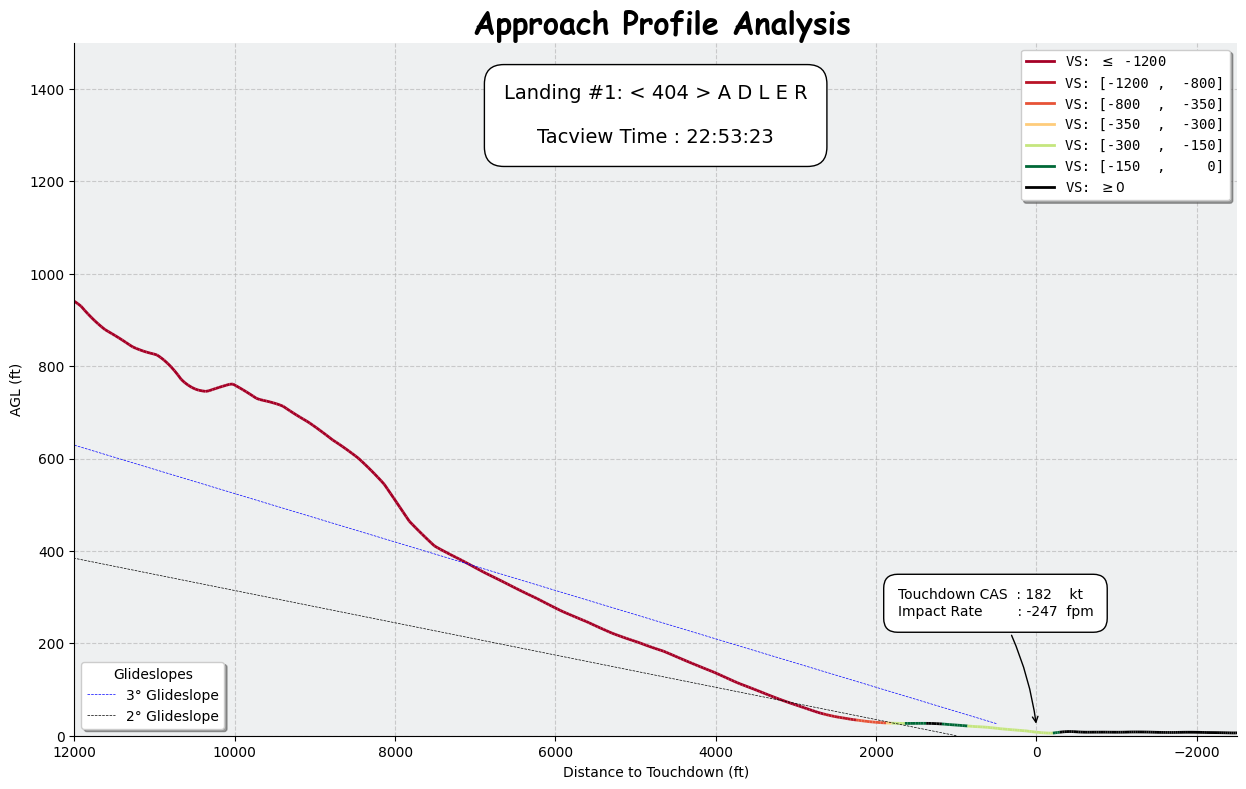

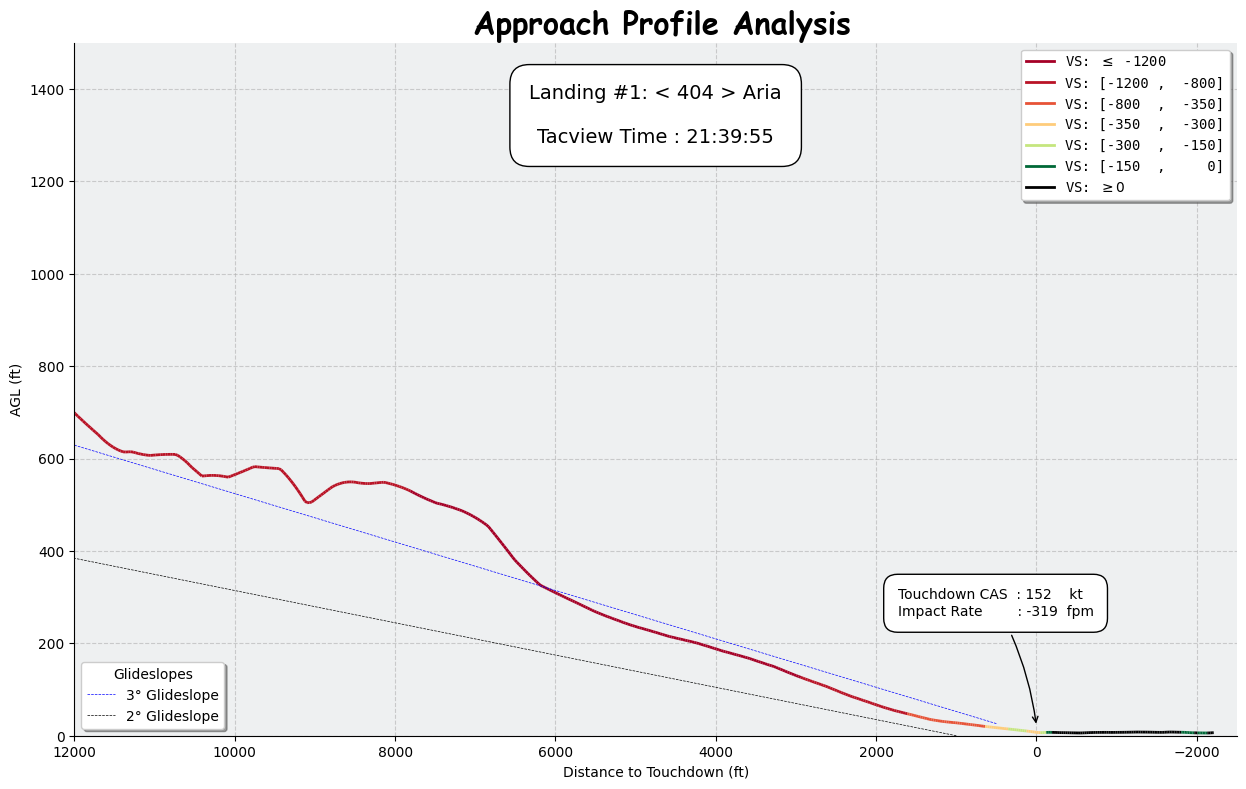

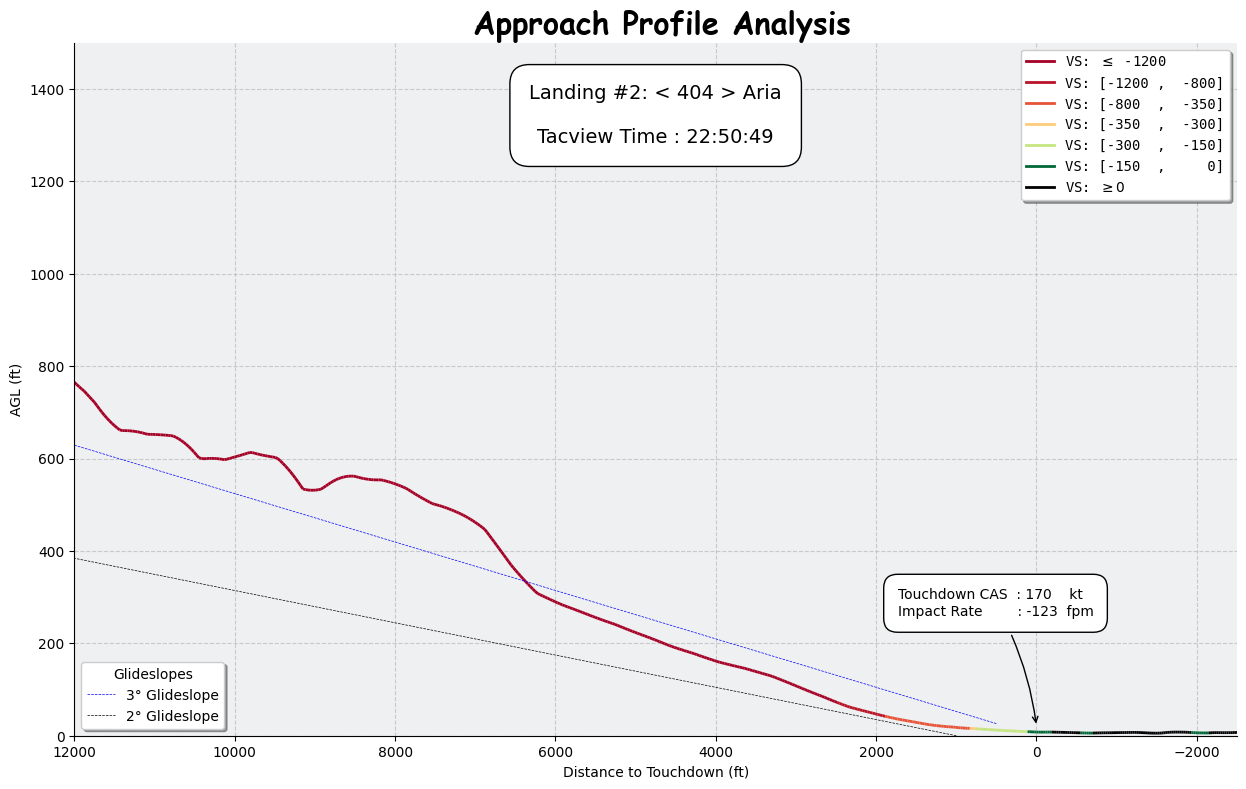

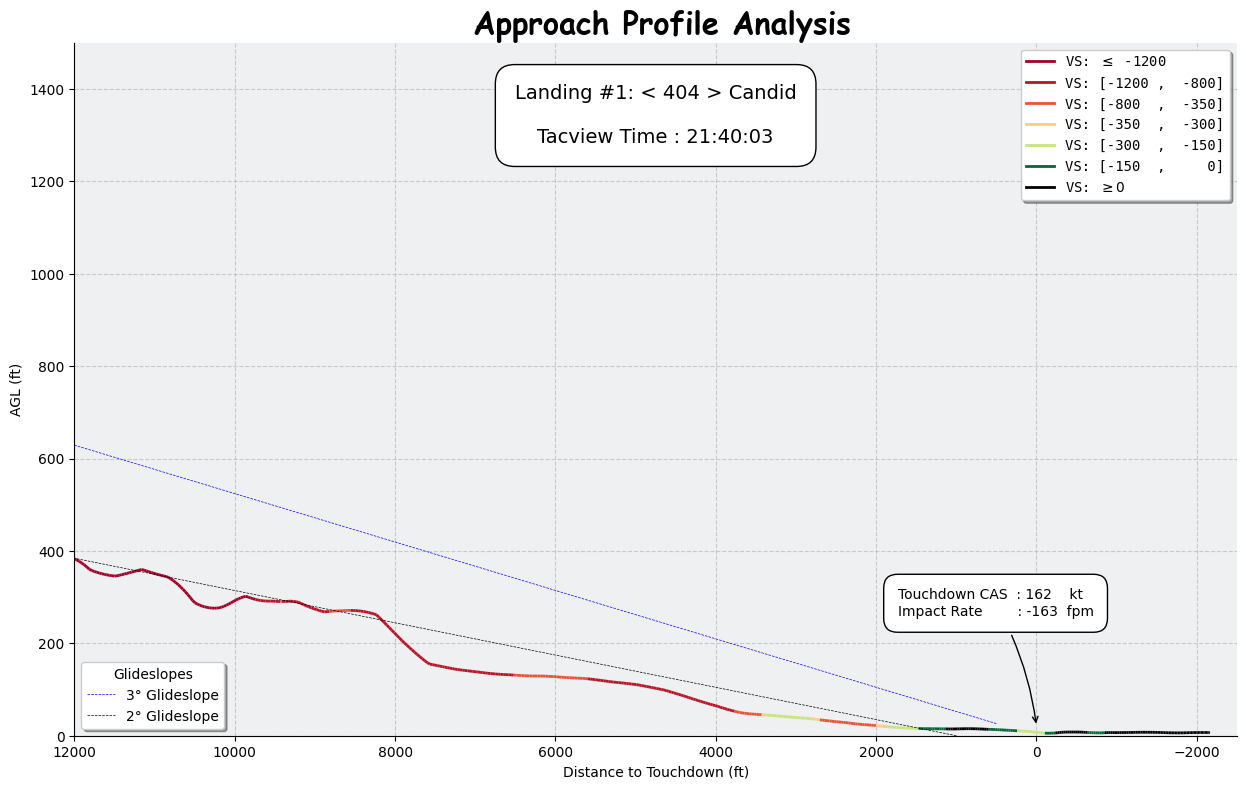

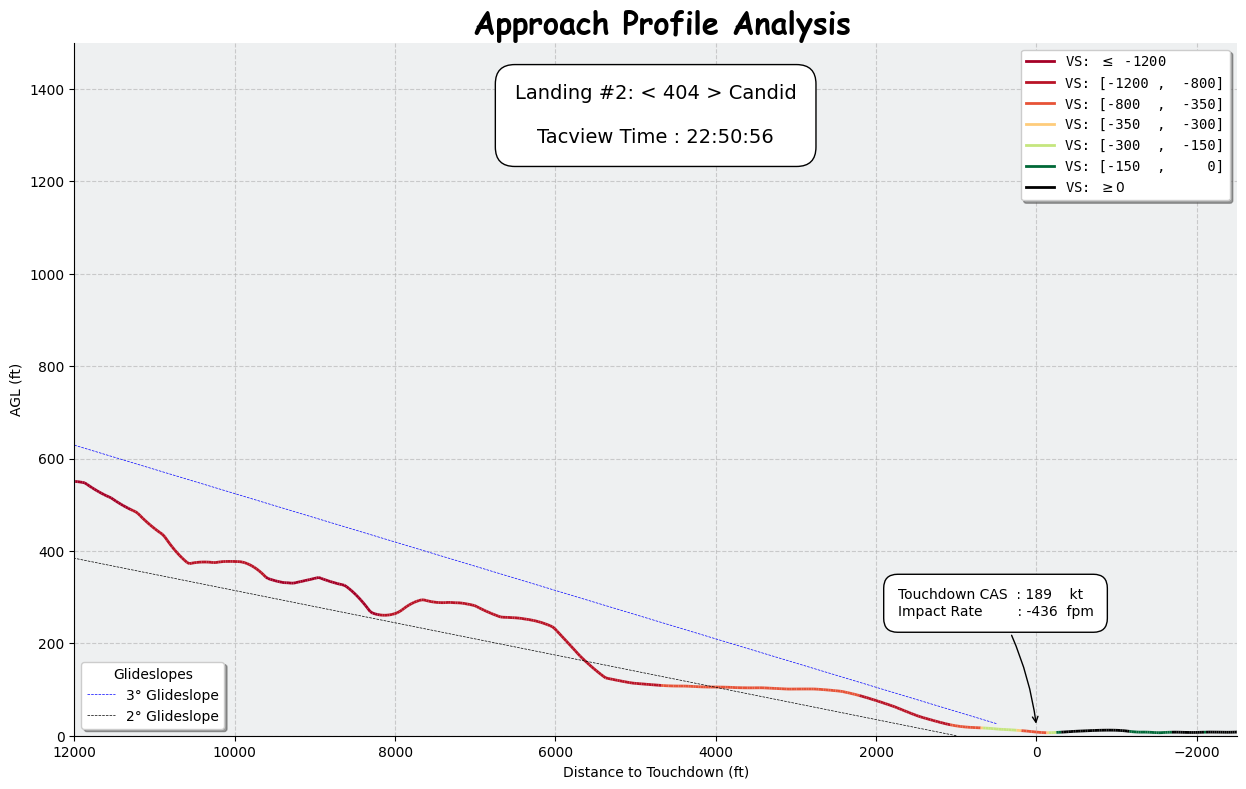

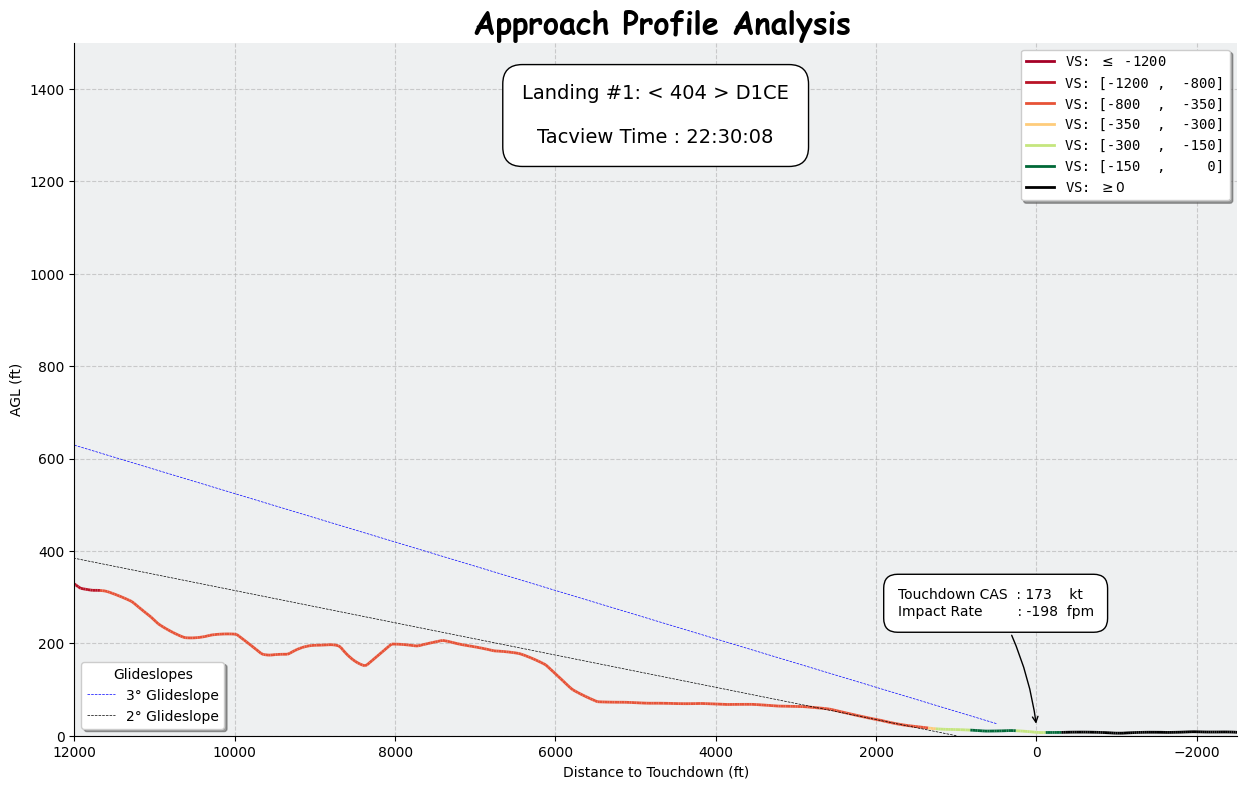

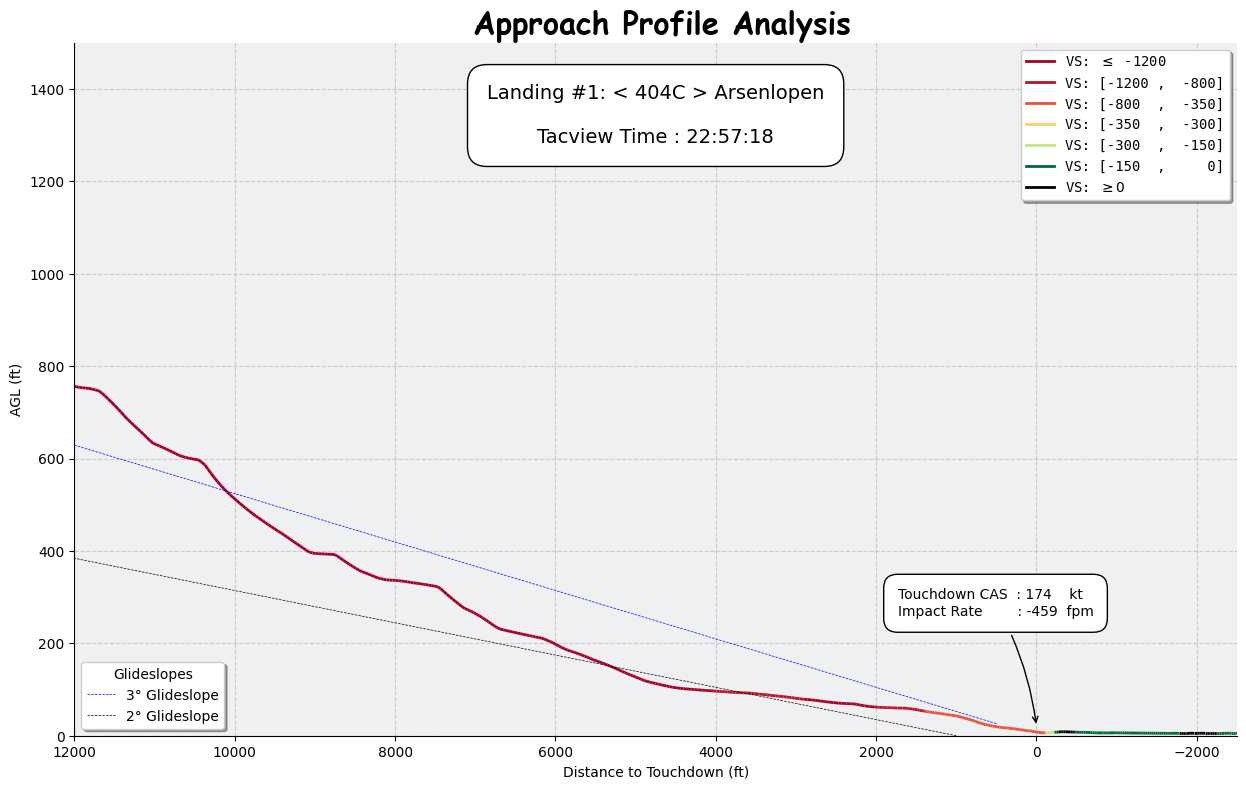

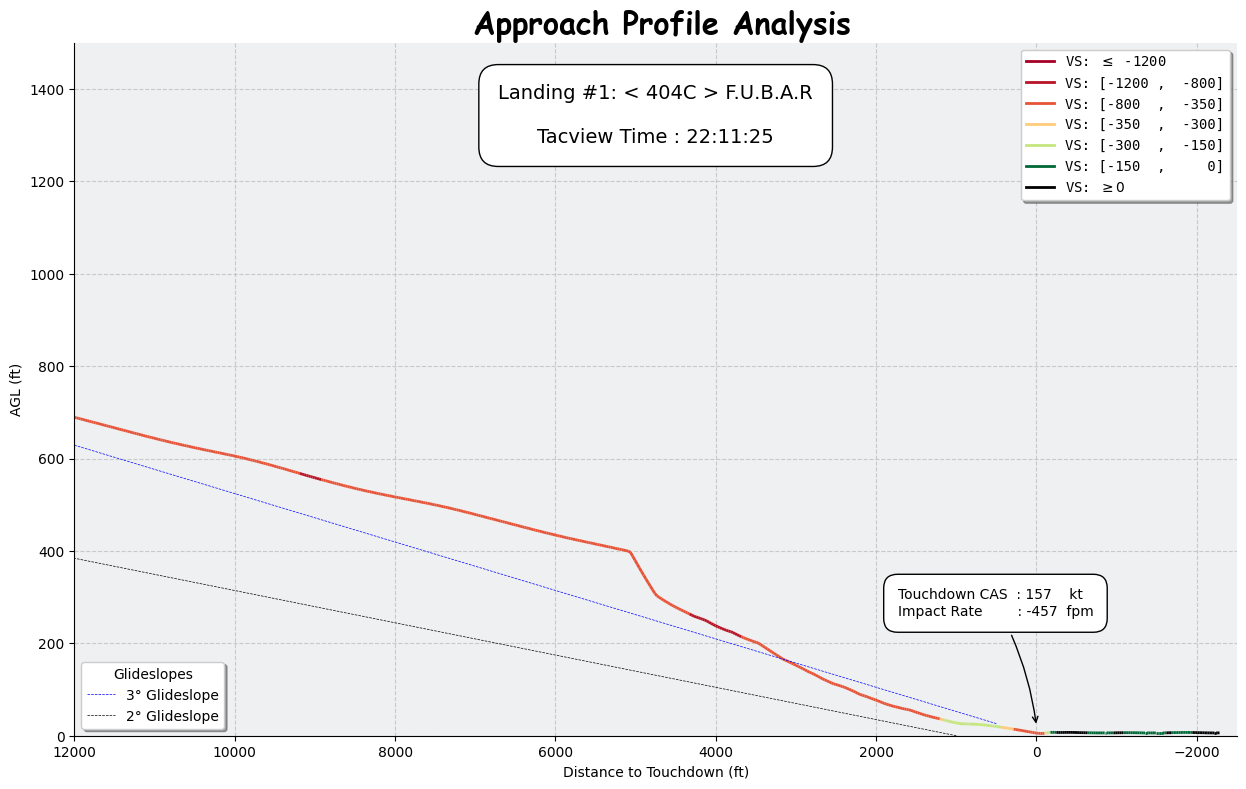

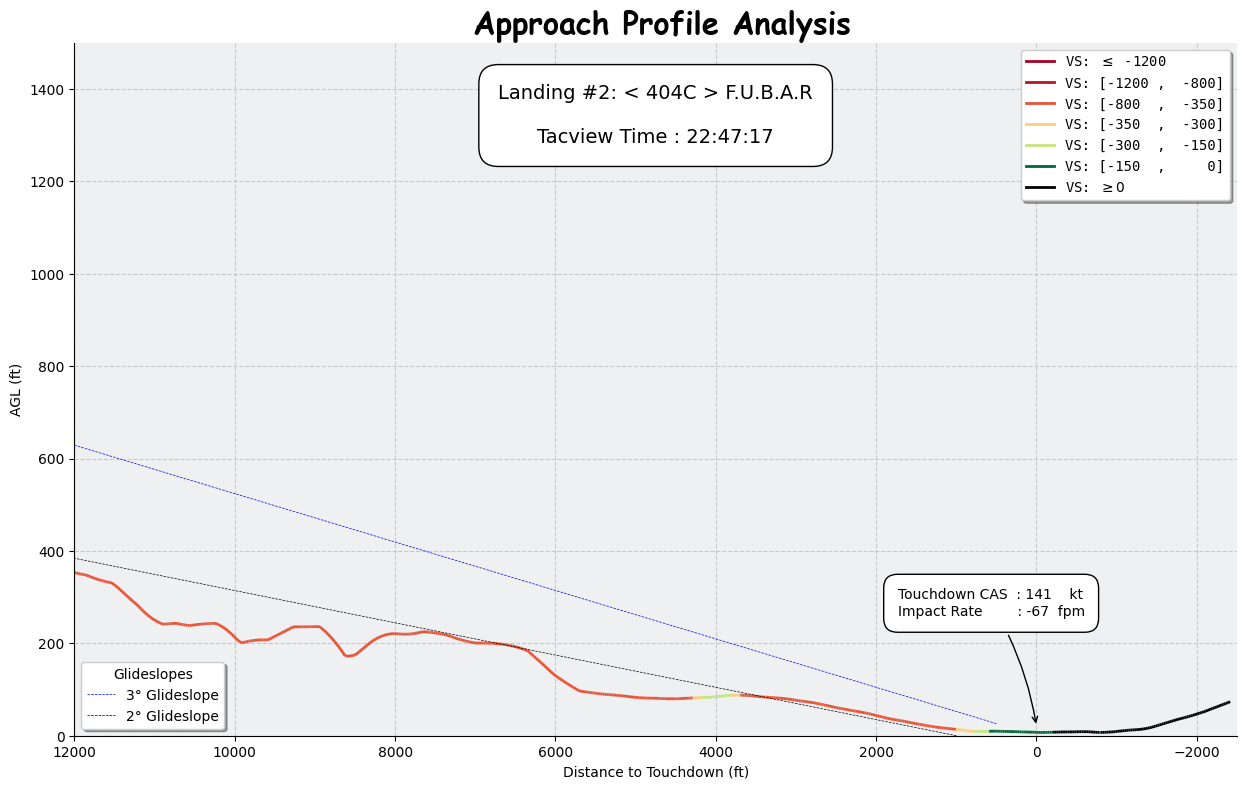

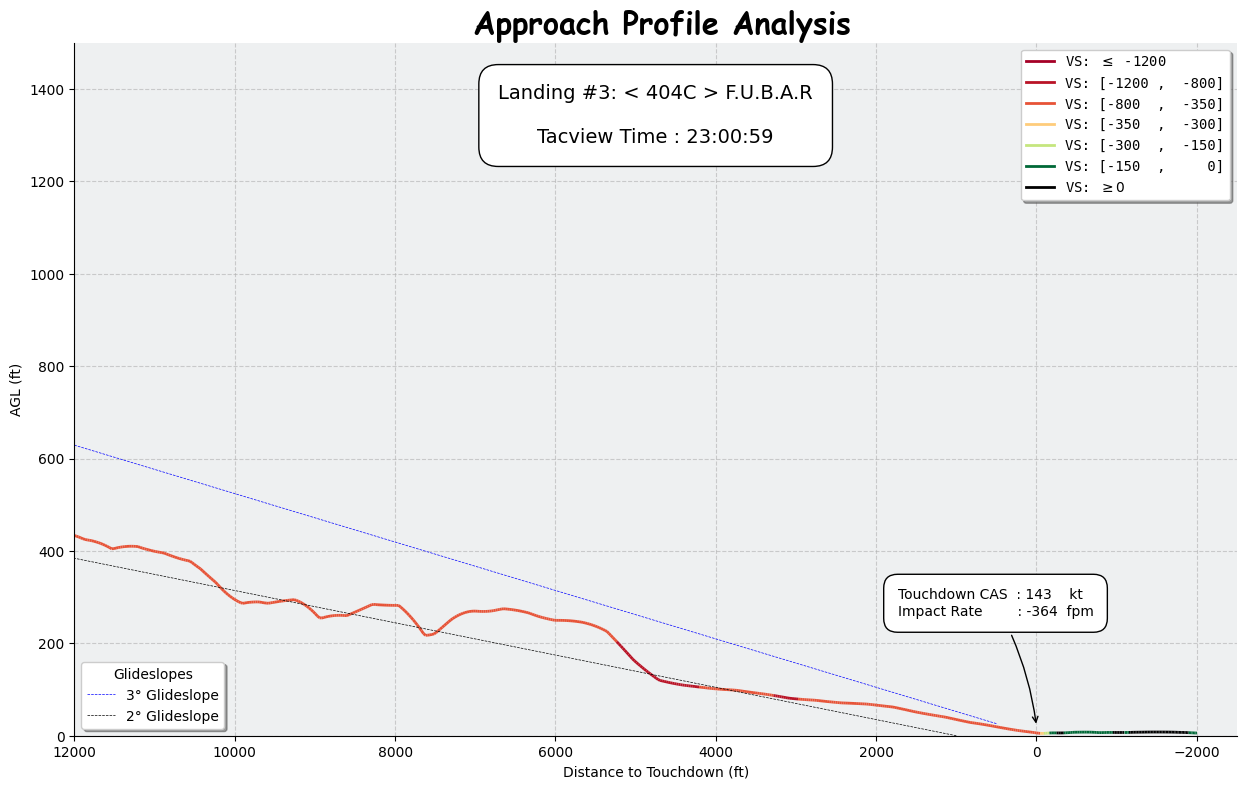

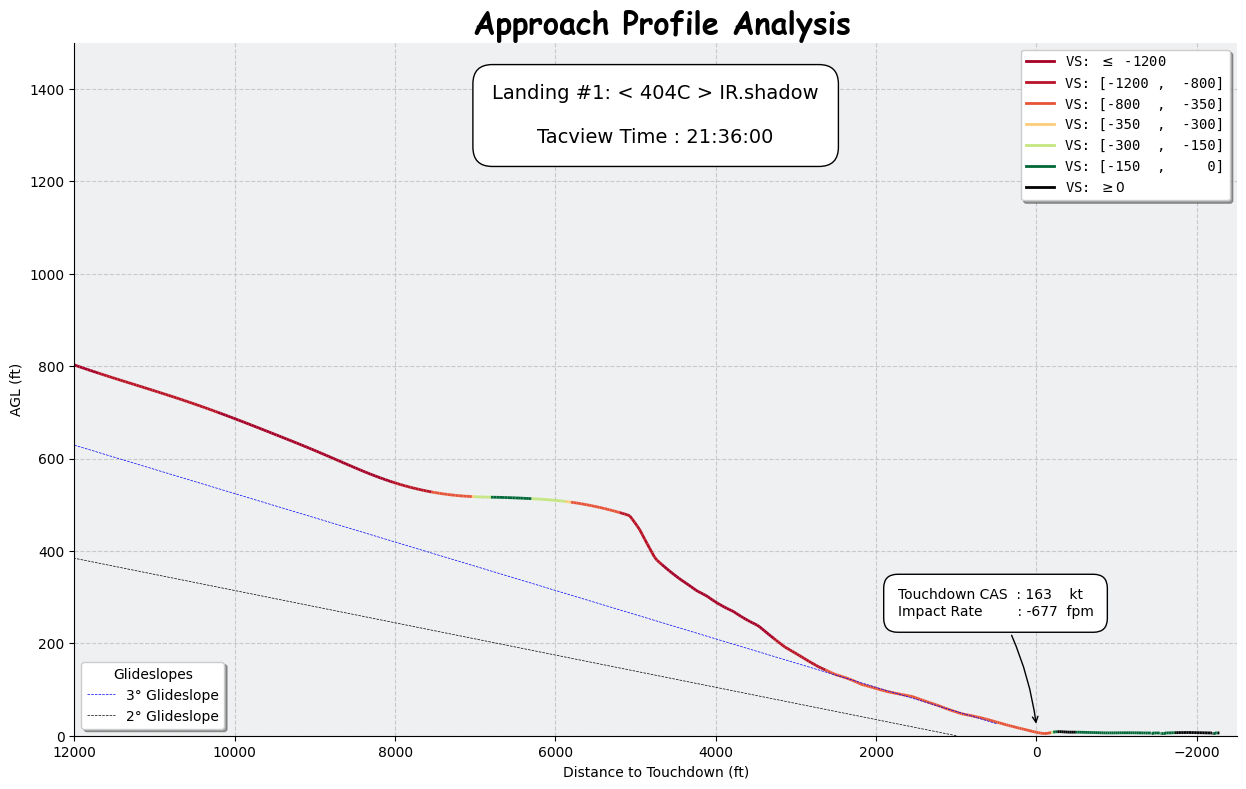

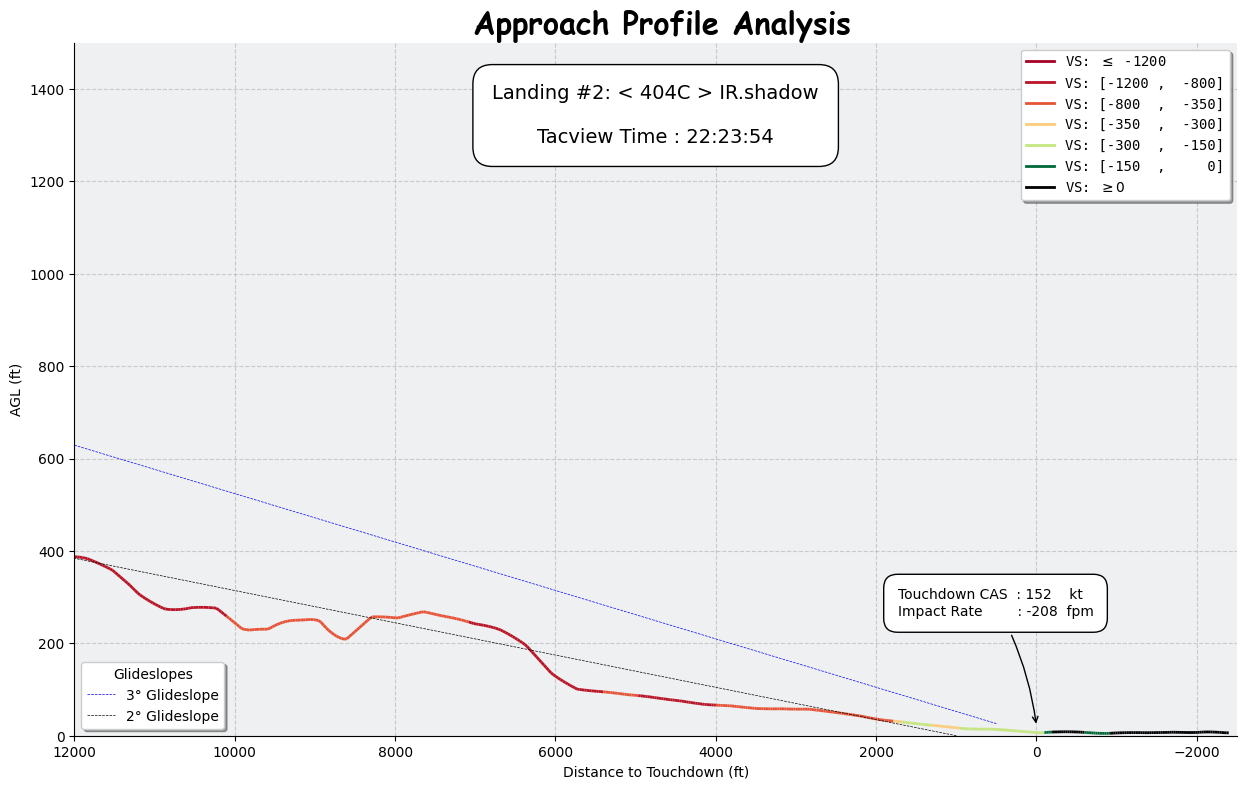

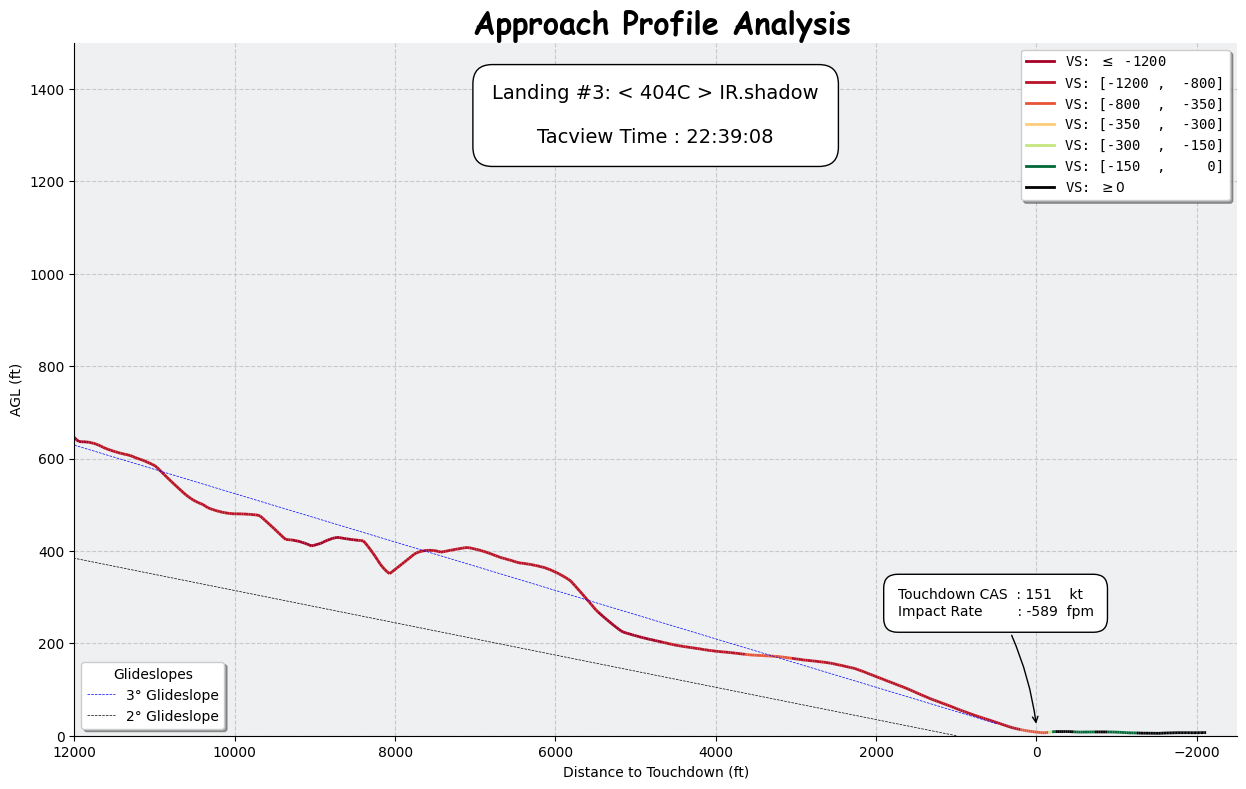

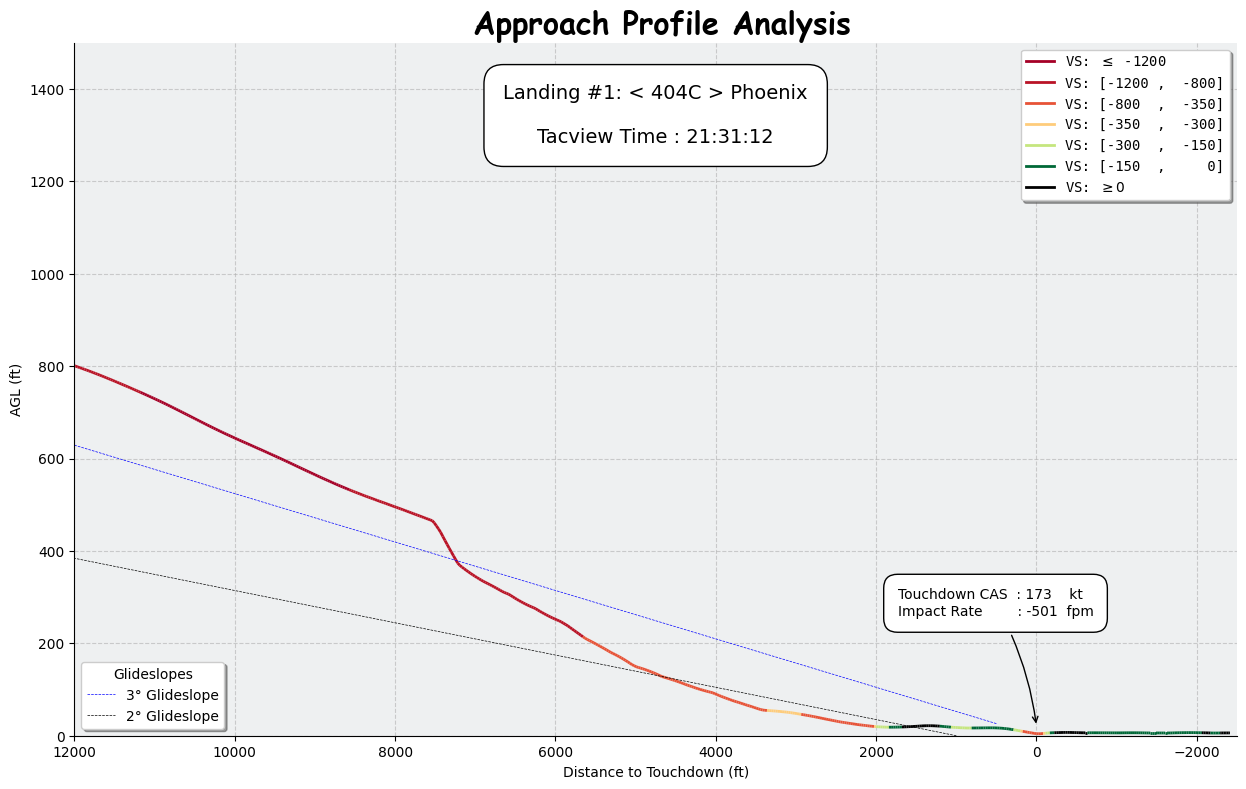

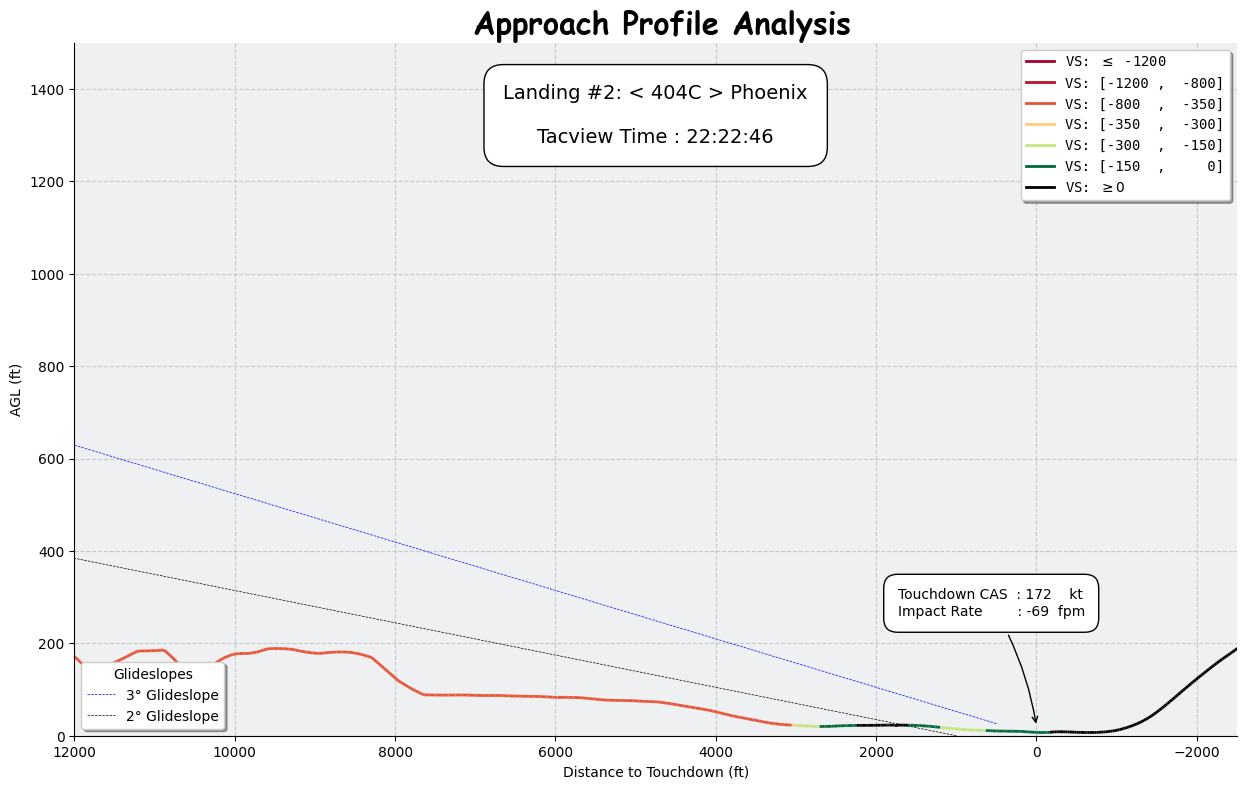

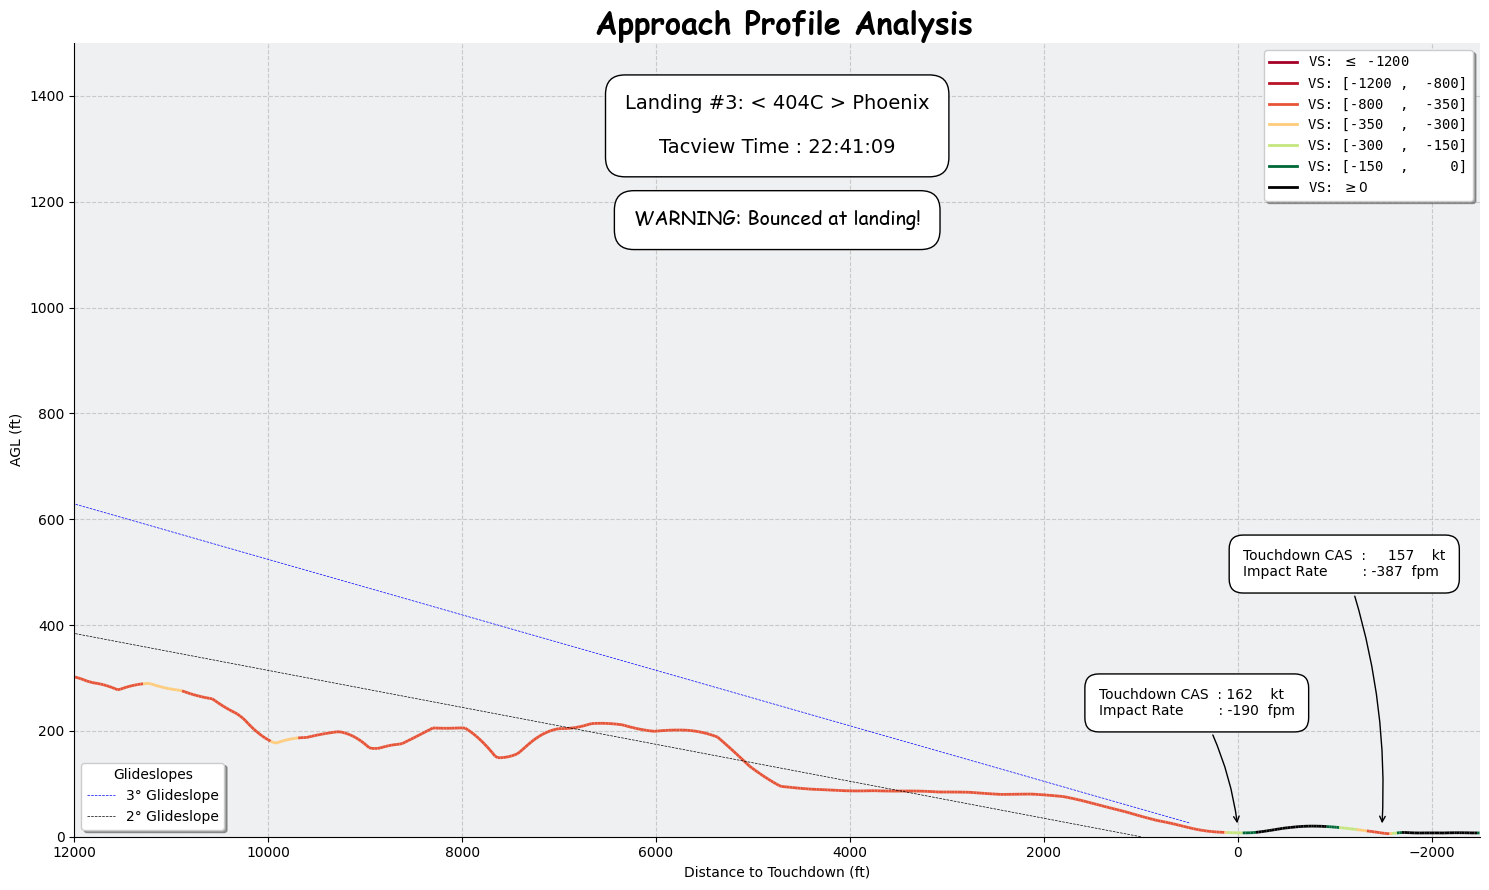

In [ ]:
# Which part of final approach are we interested in?
final_segment      = 60
post_touch_segment = 10

# ############## Thresholds and Colormaps ##############
# Select a colormap
cmap = plt.get_cmap('RdYlGn') 

# Create 'descent_rate' column
thresholds = [-np.inf, -1200, -800, -350, -300, -150, 0, np.inf]
min_thrshld = abs(sorted(thresholds)[1])   # worst threshold = 1200
max_thrshld = abs(sorted(thresholds)[-2])  # best  threshold = 150
num_categories = len(thresholds) - 1

labels = [f'$\leq$ {thresholds[1]}']
labels = labels + [f'[{thresholds[i]:<5g} , {thresholds[i+1]:5g}]' for i in range(1,len(thresholds)-2)]
labels.append(  f'$\geq 0$'  )

colors_list = [mcolors.to_hex(cmap( i**2 )) for i in np.linspace(0, 1, num_categories-1)]
colors_list.append(  '#000000'  )

color_map = dict(zip(labels, colors_list))

df_sub['descent_quality'] = pd.cut( df_sub ['VS'],
                                    bins=thresholds,
                                    labels=labels,
                                    include_lowest=True
                                  )  # include_lowest is important for the bottom boundary


# ###########################################################################################################################################
# ######################################################## Approach Plotter Function ########################################################

def approach_plotter(pilot, sortie_num):
    
    # Break if current touchdown is less than 5 second the previous one
    current_touchdown  = df_result.loc[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num    ), 'td_timestamp_seconds']
    previous_touchdown = df_result.loc[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num - 1), 'td_timestamp_seconds']
    next_touchdown     = df_result.loc[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num + 1), 'td_timestamp_seconds']
    
    # If there's no previous touchdown, we can't compare
    if not current_touchdown.empty and not previous_touchdown.empty:
      if current_touchdown.iloc[0] - previous_touchdown.iloc[0] < 10:
        print(f'Sortie #{sortie_num} of {pilot} Took less than 5 second!')
        return

    # --- Associate Every Data Point with its Upcoming Landing --- #
    # We keep the data 60s prior to touchdown and 20s after that
    df_forward = pd.merge_asof(
                              left=df_sub,
                              right=df_result.loc[ (df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num) , ['sortie_num', 'Pilot', 'td_timestamp', 'td_timestamp_seconds', 'td_longitude', 'td_latitude']],
                              left_on='timestamp_seconds',
                              right_on='td_timestamp_seconds',
                              by='Pilot',
                              direction='forward',        # Look to prior to touchdown
                              tolerance= final_segment    # Only match if the touchdown is <= 60 seconds away
                              )
    df_backward = pd.merge_asof(
                              left=df_sub,
                              right=df_result.loc[ (df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num) , ['sortie_num', 'Pilot', 'td_timestamp', 'td_timestamp_seconds', 'td_longitude', 'td_latitude']],
                              left_on='timestamp_seconds',
                              right_on='td_timestamp_seconds',
                              by='Pilot',
                              direction='backward',               # toward next sortie
                              tolerance= post_touch_segment,      # Only match if the touchdown is <= 20 seconds away
                              allow_exact_matches = False         # Touchdown entry itself is already included in df_forward
                                )
    # Only keeping entries upto 60s prior to touchdown or 20s after touchdown
    df_forward  = df_forward .dropna(subset=['td_latitude'])
    df_backward = df_backward.dropna(subset=['td_latitude'])

    # Calculate Distances prior to Touchdown
    df_forward['distance_to_touchdown']  = df_forward.apply (lambda row:   haversine( row['Latitude'], 
                                                                                      row['Longitude'], 
                                                                                      row['td_latitude'],
                                                                                      row['td_longitude']
                                                                                    )                     ,axis=1)
    # Calculate Distances after Touchdown (negative direction)
    df_backward['distance_to_touchdown'] = df_backward.apply(lambda row: - haversine( row['td_latitude'], 
                                                                                      row['td_longitude'], 
                                                                                      row['Latitude'],
                                                                                      row['Longitude']
                                                                                    )                     ,axis=1)

    # following td columns should follow the same calculations as the flight prior to touchdown
    df_backward.rename(columns={'sortie_num'           : 'sortie_extended'               }, inplace=True)
    df_backward.rename(columns={'td_timestamp'         : 'td_timestamp_extended'         }, inplace=True)
    df_backward.rename(columns={'td_timestamp_seconds' : 'td_timestamp_seconds_extended' }, inplace=True)
    df_backward.rename(columns={'td_longitude'         : 'td_longitude_extended'         }, inplace=True)
    df_backward.rename(columns={'td_latitude'          : 'td_latitude_extended'          }, inplace=True)
    df_backward.rename(columns={'distance_to_touchdown': 'distance_to_touchdown_extended'}, inplace=True)

    # sortie to integer
    df_forward['sortie_num']  = df_forward ['sortie_num'].astype(int)
    df_backward['sortie_extended'] = df_backward['sortie_extended'].astype(int)

    # Merging: contains data 60s prior to touchdowns to 20 second after
    common_columns = list(set(df_forward.columns) & set(df_backward.columns))
    df_final_approach_merge = pd.merge(df_forward, df_backward, on=common_columns, how='outer').sort_values(by='timestamp_seconds')
  
    # Filter for the current pilot and sortie number
    df_plot = df_final_approach_merge[ 
                                        (  df_final_approach_merge['Pilot'] == pilot) & \
                                        ( (df_final_approach_merge['sortie_num']        == sortie_num  ) + \
                                          (df_final_approach_merge['sortie_extended']   == sortie_num  )
                                        )
                                    ]

    df_plot['distance_to_touchdown_plot'] = np.where( df_plot['distance_to_touchdown_extended'].isnull(),
                                                      df_plot['distance_to_touchdown']                  ,
                                                      df_plot['distance_to_touchdown_extended']  
                                                    )

    # Ensure the DataFrame is not empty
    if df_plot.empty:
        print(f"No data available for {pilot} with sortie number {sortie_num}")
        return
    
    # Map colors to descent_qualities
    colors = df_plot['descent_quality'].map(color_map, na_action=None)

    # Create segments for the LineCollection
    points = np.array([df_plot['distance_to_touchdown_plot'], df_plot['AGL']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection object
    # The colors are applied to each segment
    lc = LineCollection(segments, colors=colors[:-1], linewidths=2)
    
    # PLOTTING
    fig, ax = plt.subplots(figsize=(15, 9))
    
    ax.add_collection(lc)
    ax.autoscale_view()

    # BACKGROUND GRAPHICS
    ax.grid(True, linestyle='--', alpha=0.6) # Added gridlines, adjusted alpha
    ax.set_facecolor("#EEF0F1FF")

    # AXES LIMITS
    ax.set_xlim(-2500, 12000)
    ax.set_ylim(0, 1500)

    ax.invert_xaxis() # Invert x-axis to show glideslope

    # LABELS & TITLES
    ax.set_ylabel('AGL (ft)')
    ax.set_xlabel('Distance to Touchdown (ft)')

    ax.set_title(f' Approach Profile Analysis', fontsize=22, fontweight='bold', family='cursive')
    ax.text(np.mean(ax.get_xlim())*1, ax.get_ylim()[1]*0.9, 
            f'Landing #{sortie_num}: {df_plot["Pilot"].iloc[0]}\n\n'
            f"Tacview Time : {df_result [
                                        (df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num)
                                        ]['td_timestamp'].astype(str).iloc[0][:8]}", 
            fontsize=14, ha='center', va= 'center_baseline', color='k',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

    # DESPINE
    sns.despine(ax=ax)

    # Create LEGEND
    color_map_last_segments = {k: color_map[k] for k in list(color_map.keys())[:]}
    legend_elements = [Line2D([0], [0], color=color, lw=2, label=f'VS: {label}')
                    for label, color in color_map_last_segments.items()]
    
    legend1 = ax.legend(handles=legend_elements, prop={'family': 'monospace', 'size': 10}, 
              bbox_to_anchor=(1., 1), loc='upper right', shadow=True)

    # ANNOTATIONS
    td_vs_fpm      = df_result[df_result['Pilot'] == pilot]['VS_fpm'].iloc[sortie_num-1]
    td_cas_kt      = df_result[df_result['Pilot'] == pilot]['CAS_kt'].iloc[sortie_num-1]

    # If there exist a next touchdown in less than 10s
    if not current_touchdown.empty and not next_touchdown.empty:
      if (sortie_num < len(df_result[df_result['Pilot'] == pilot])) and (next_touchdown.iloc[0] - current_touchdown.iloc[0] < 10):
          td_vs_fpm_next = df_result[df_result['Pilot'] == pilot]['VS_fpm'].iloc[sortie_num]
          td_cas_kt_next = df_result[df_result['Pilot'] == pilot]['CAS_kt'].iloc[sortie_num]
          distance_to_next_td = - haversine(  df_result[df_result['Pilot'] == pilot]['td_latitude'] .iloc[sortie_num-1] , 
                                              df_result[df_result['Pilot'] == pilot]['td_longitude'].iloc[sortie_num-1], 
                                              df_result[df_result['Pilot'] == pilot]['td_latitude'].iloc[sortie_num], 
                                              df_result[df_result['Pilot'] == pilot]['td_longitude'].iloc[sortie_num]
                                            )
          # Pointing to next bounding point
          ax.annotate(f"Touchdown CAS  :     {int(td_cas_kt_next)}    kt\n"
                      f"Impact Rate        : {int(td_vs_fpm_next)}  fpm", 
                      arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3, rad=-0.1"), 
                      xy= (distance_to_next_td,20), xytext=(0.04*ax.get_xlim()[1],180), textcoords="offset points", fontsize=10, ha='left',
                      bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
          
          # Warning: your aircraft bounded
          ax.text(np.mean(ax.get_xlim()), ax.get_ylim()[1]*0.8-30, 
            f"WARNING: Bounced at landing!", 
            fontsize=14, ha='center', va= 'center_baseline', color='k', family='cursive',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

    ax.annotate(f"Touchdown CAS  : {int(td_cas_kt)}    kt\n"
                f"Impact Rate        : {int(td_vs_fpm)}  fpm", 
                arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3, rad=-0.1"), 
                xy= (0,20), xytext=(0.04*ax.get_xlim()[1],80), textcoords="offset points", fontsize=10, ha='left',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    ## TEST
    # index = df_plot[df_plot['timestamp'] >= ]
    # display (
    #         df_result[df_result['Pilot'] == pilot]['td_latitude'] .iloc[sortie_num-1],
    #         distance_to_next_td
    #         )
    ## TEST
    
    # GLIDESLOPE
    x_glideslope = np.append(np.linspace(0, 500, 11), 15000)

    y_glideslope_3deg = x_glideslope * np.tan(3 * np.pi / 180)
    y_glideslope_2deg = x_glideslope * np.tan(2 * np.pi / 180)

    index_300 = np.where(x_glideslope >= 500)[0]
    
    line_3deg, = ax.plot(x_glideslope[index_300], y_glideslope_3deg[index_300], color='blue', linestyle='--', linewidth=0.5)
    line_2deg, = ax.plot(x_glideslope + 1000     , y_glideslope_2deg, color='k', linestyle='--', linewidth=0.5)

    # GLIDESLOPE LEGEND
    legend2 = ax.legend([line_3deg, line_2deg], ['3° Glideslope', '2° Glideslope'], 
              loc='lower left', title='Glideslopes', facecolor='w', shadow=True)
    ax.add_artist(legend1)

    # EXPORT PLOTS
    fig.savefig(os.path.join(results_dir, f'[{date_tacview}] {extract_pilot_name(pilot)}_landing_{sortie_num}.png'), dpi=300, bbox_inches='tight')


###########################################    End of Function    ##############################################
################################################################################################################


############## Creating subplots landings ##############

# approach_plotter('< 404C > Phoenix', 3)
for pilot in observed_Pilots:
    for sortie in df_result[df_result['Pilot'] == pilot]['sortie_num'].unique():
        approach_plotter(pilot, sortie)

plt.style.use('default')
plt.tight_layout()
plt.show()

## Technical Visualization: Touchdown/Impact

In [12]:
def format_seconds(seconds, pos=None):
    '''Converts seconds into HH:MM:SS format for time axis.'''
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    return f'{hours:02}:{minutes:02}:{seconds:05.2f}'


In [13]:
if -df_result[(df_result['Pilot'] == '< 404C > Phoenix') & (df_result['sortie_num'] == 3)] ['td_timestamp_seconds'].iloc[0]:
    print('hello')

hello


In [128]:
df_result[df_result['Pilot'] == '< 404C > Phoenix']

df_result.loc[(df_result['Pilot'] == '< 404C > Phoenix') & (df_result['sortie_num'] == 4), 'td_timestamp_seconds']

10    81674.693136
Name: td_timestamp_seconds, dtype: float64

Sortie #4 of < 404C > Phoenix Took less than 5 second!


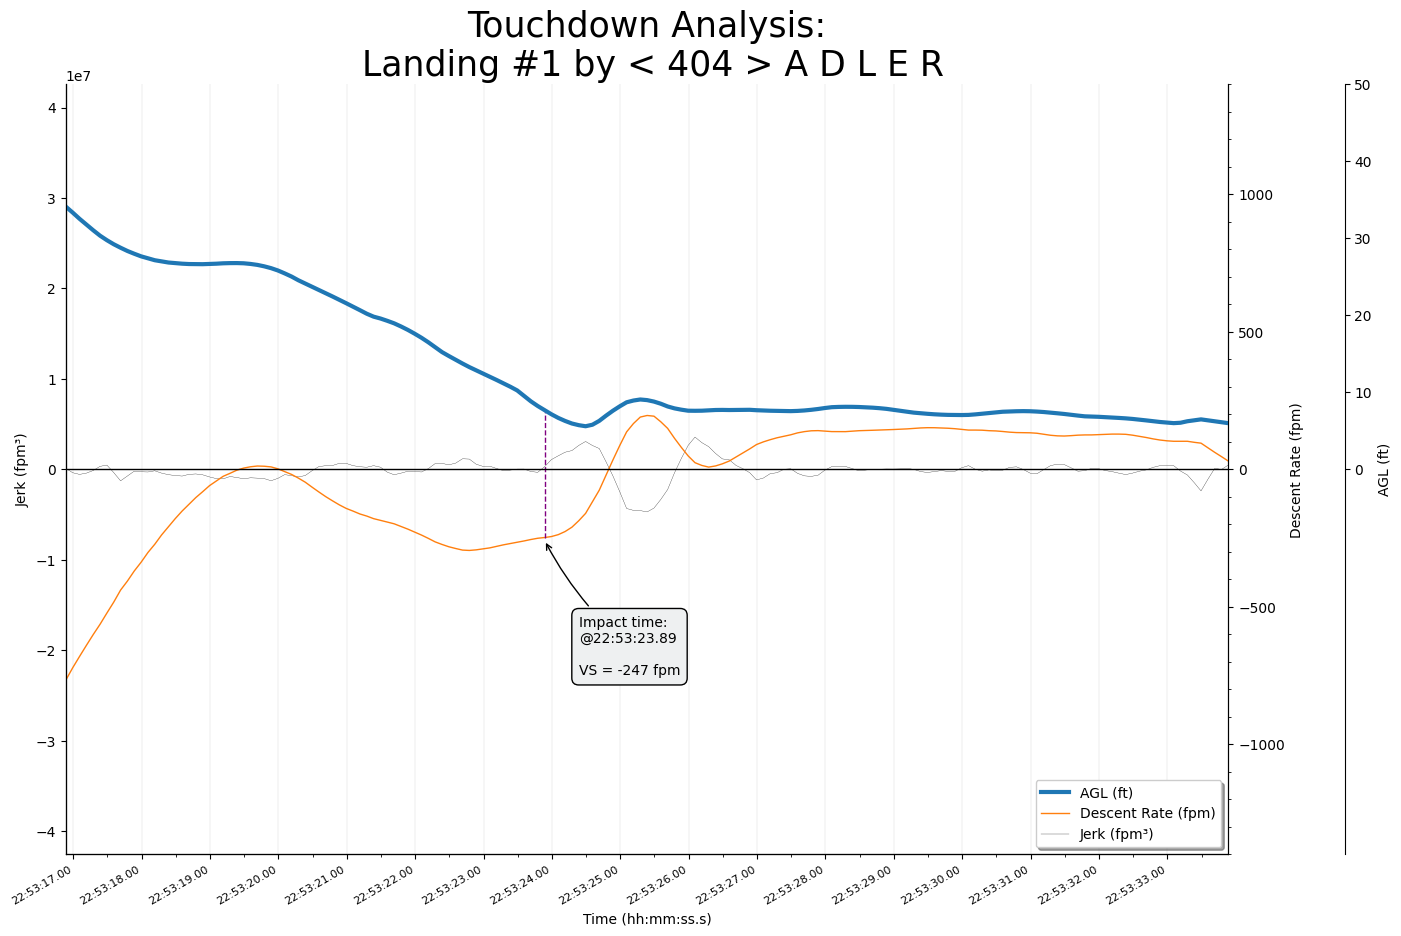

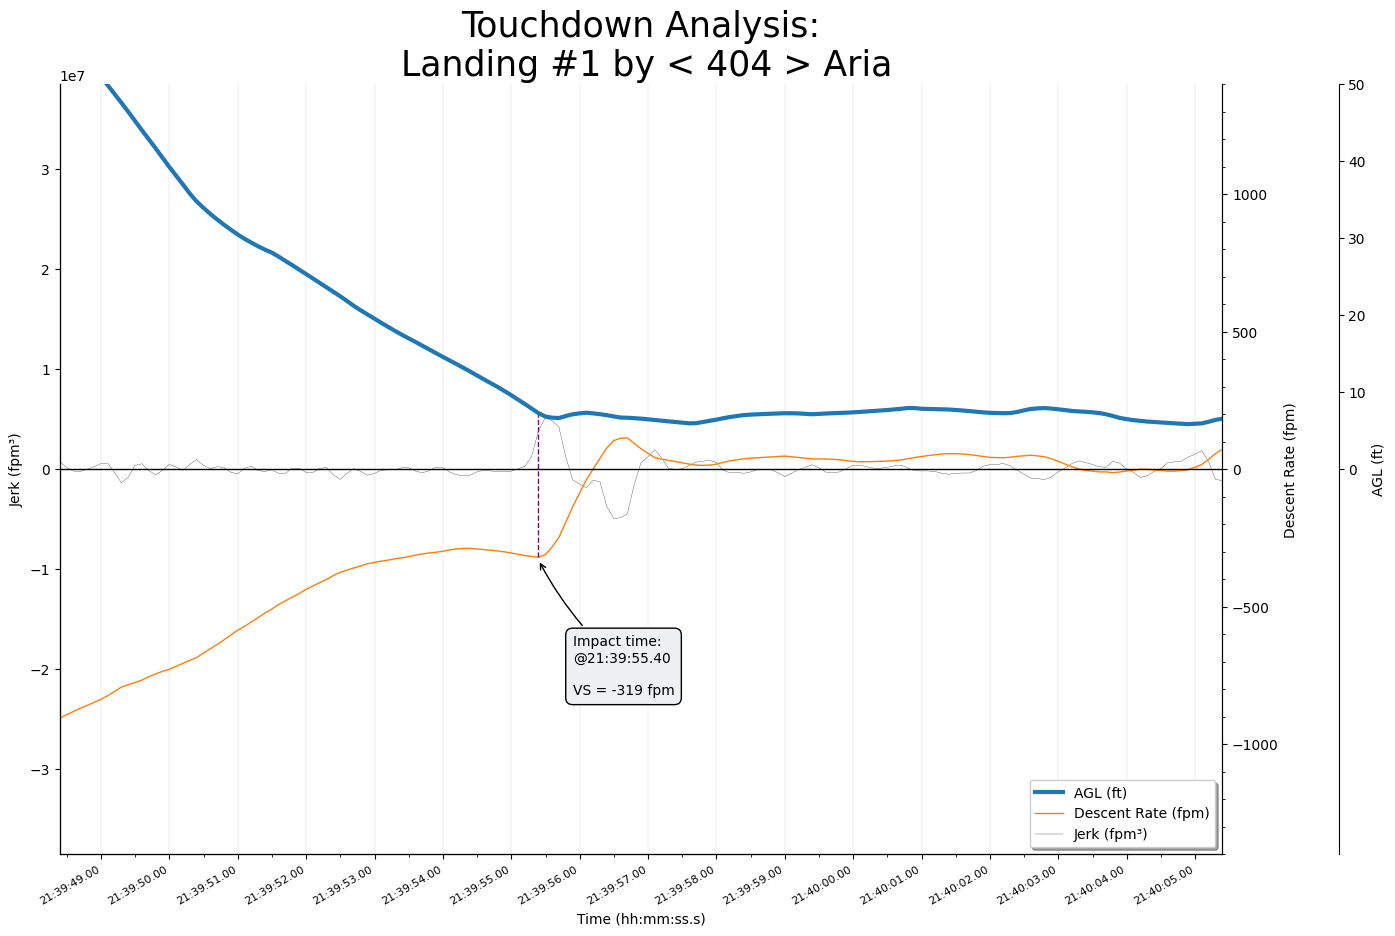

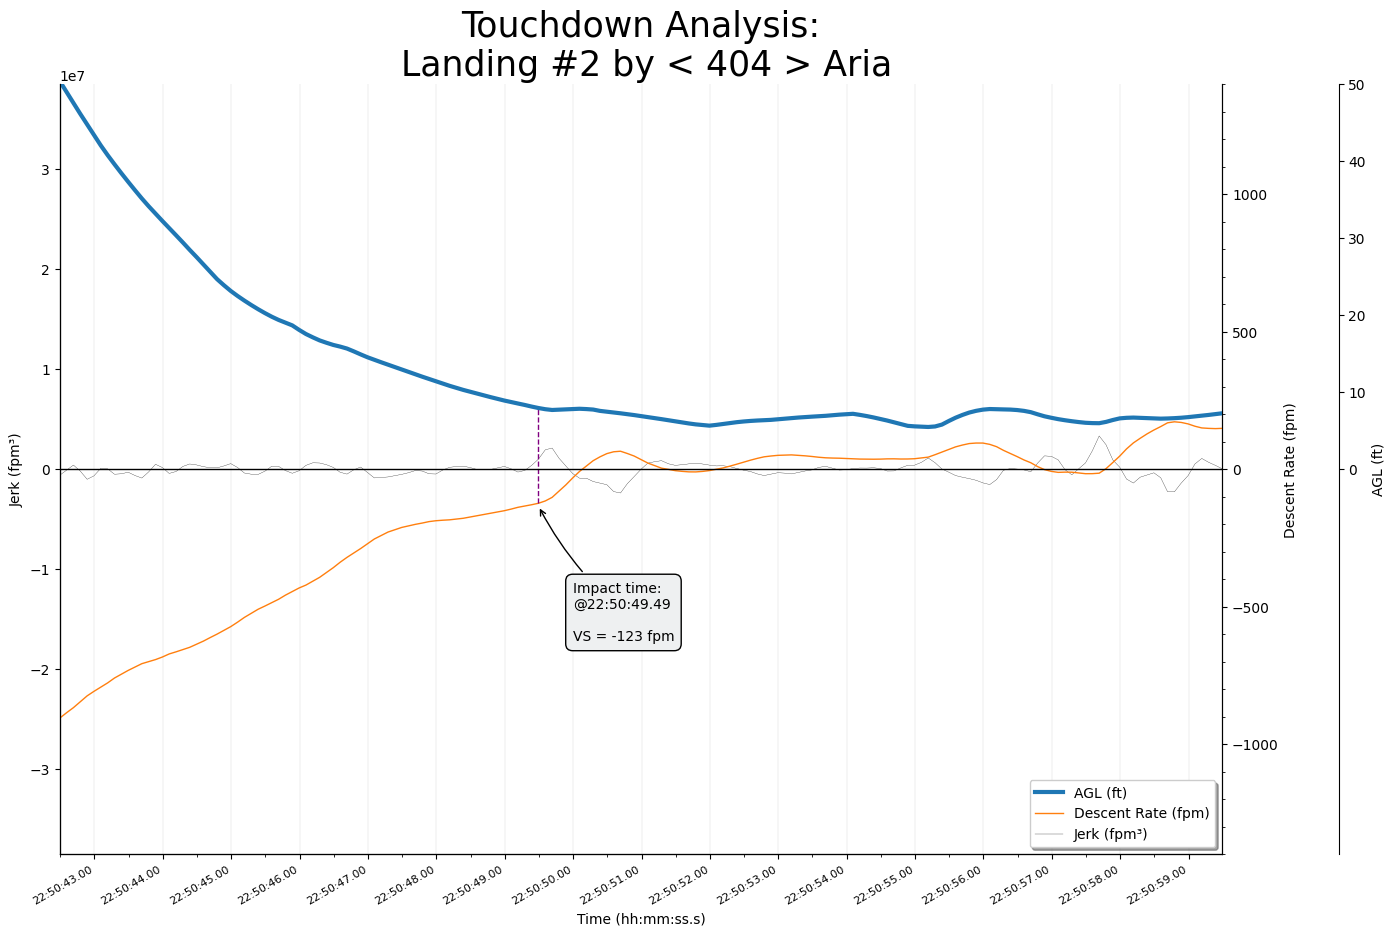

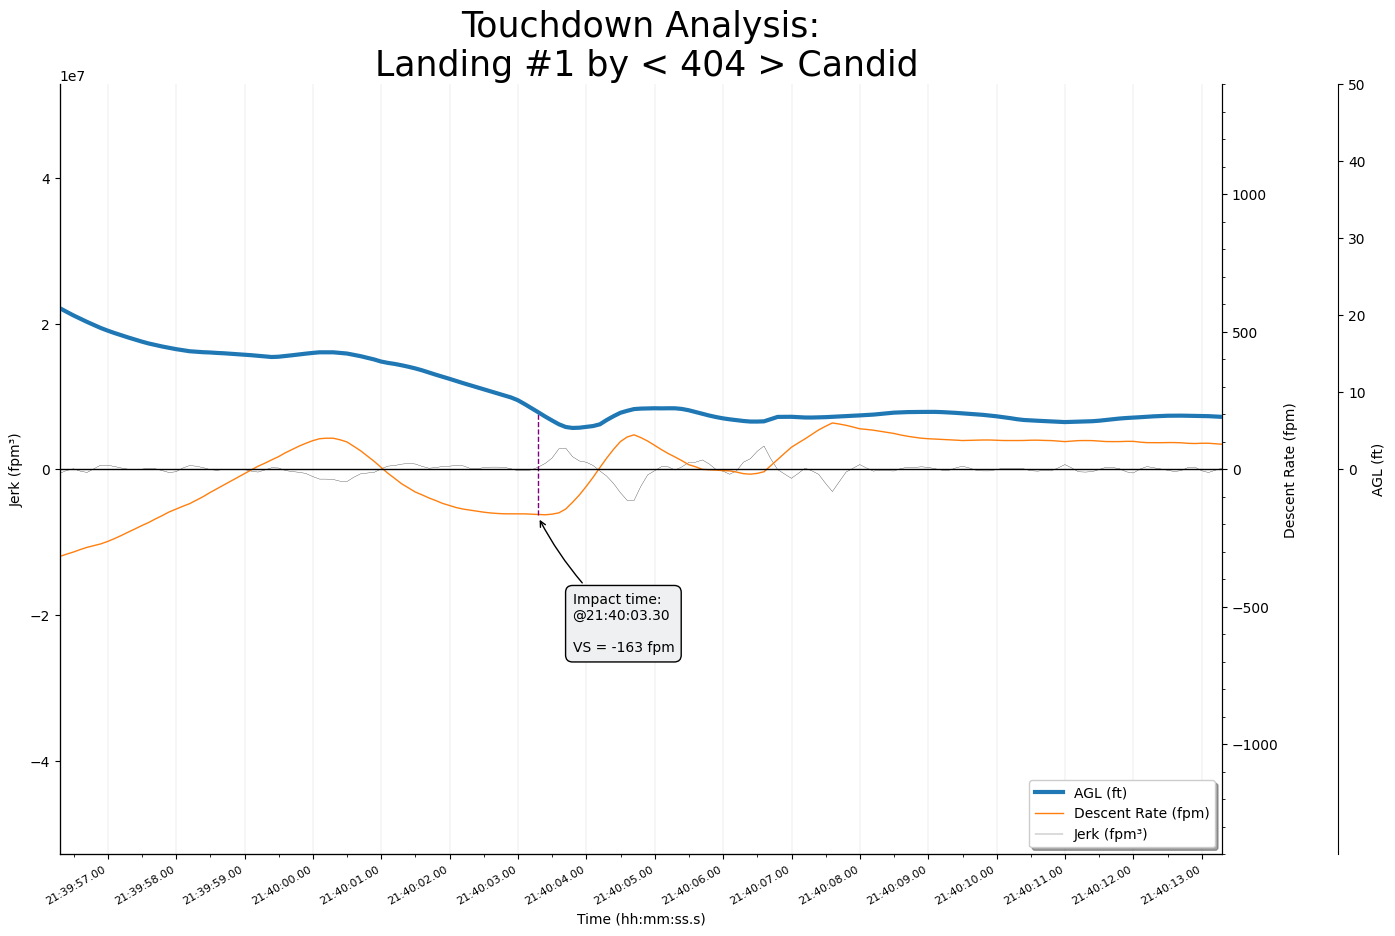

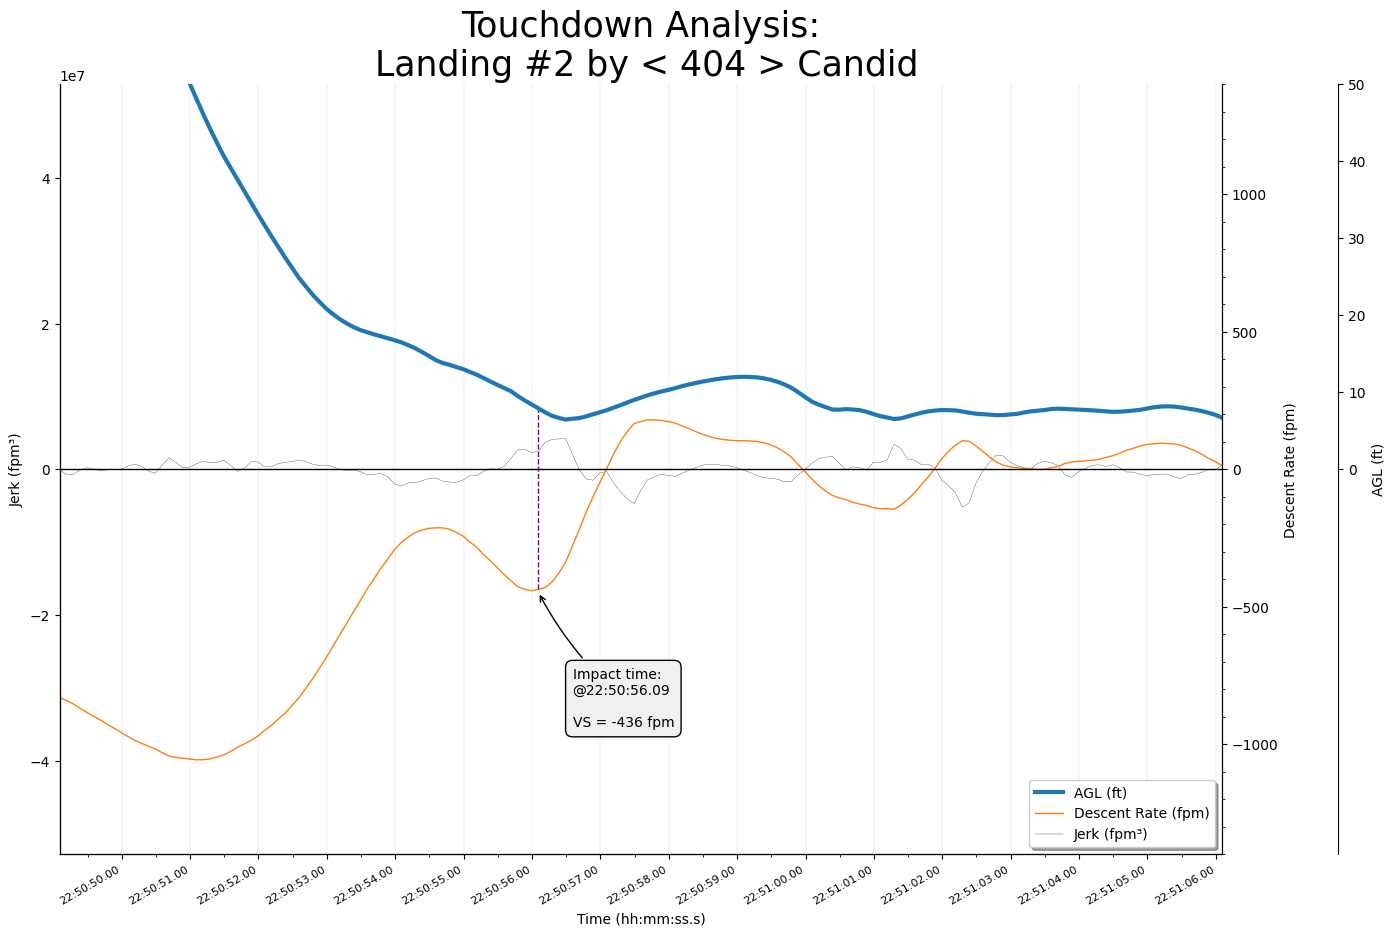

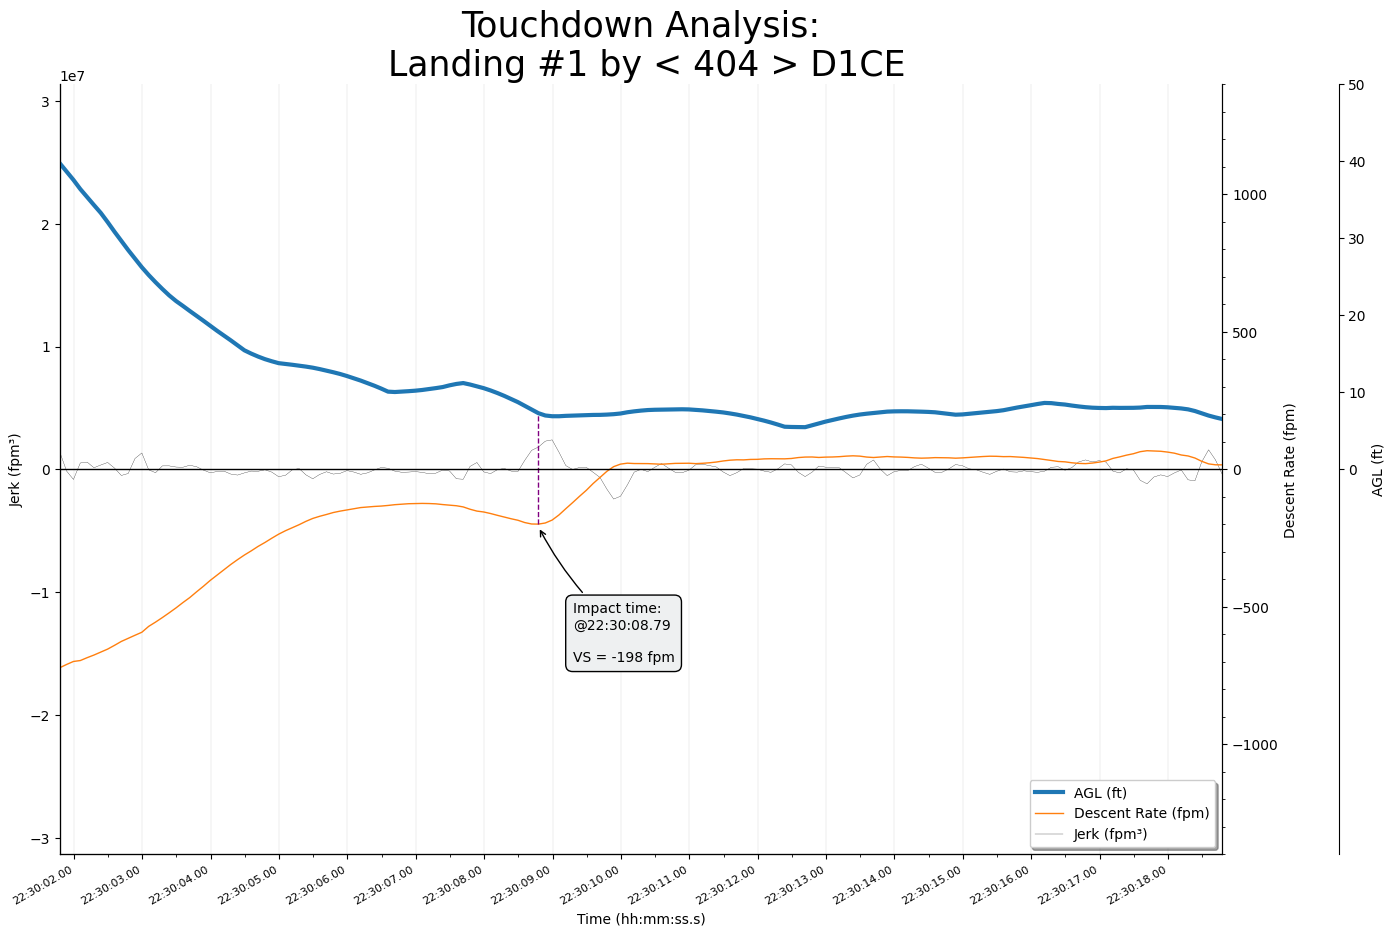

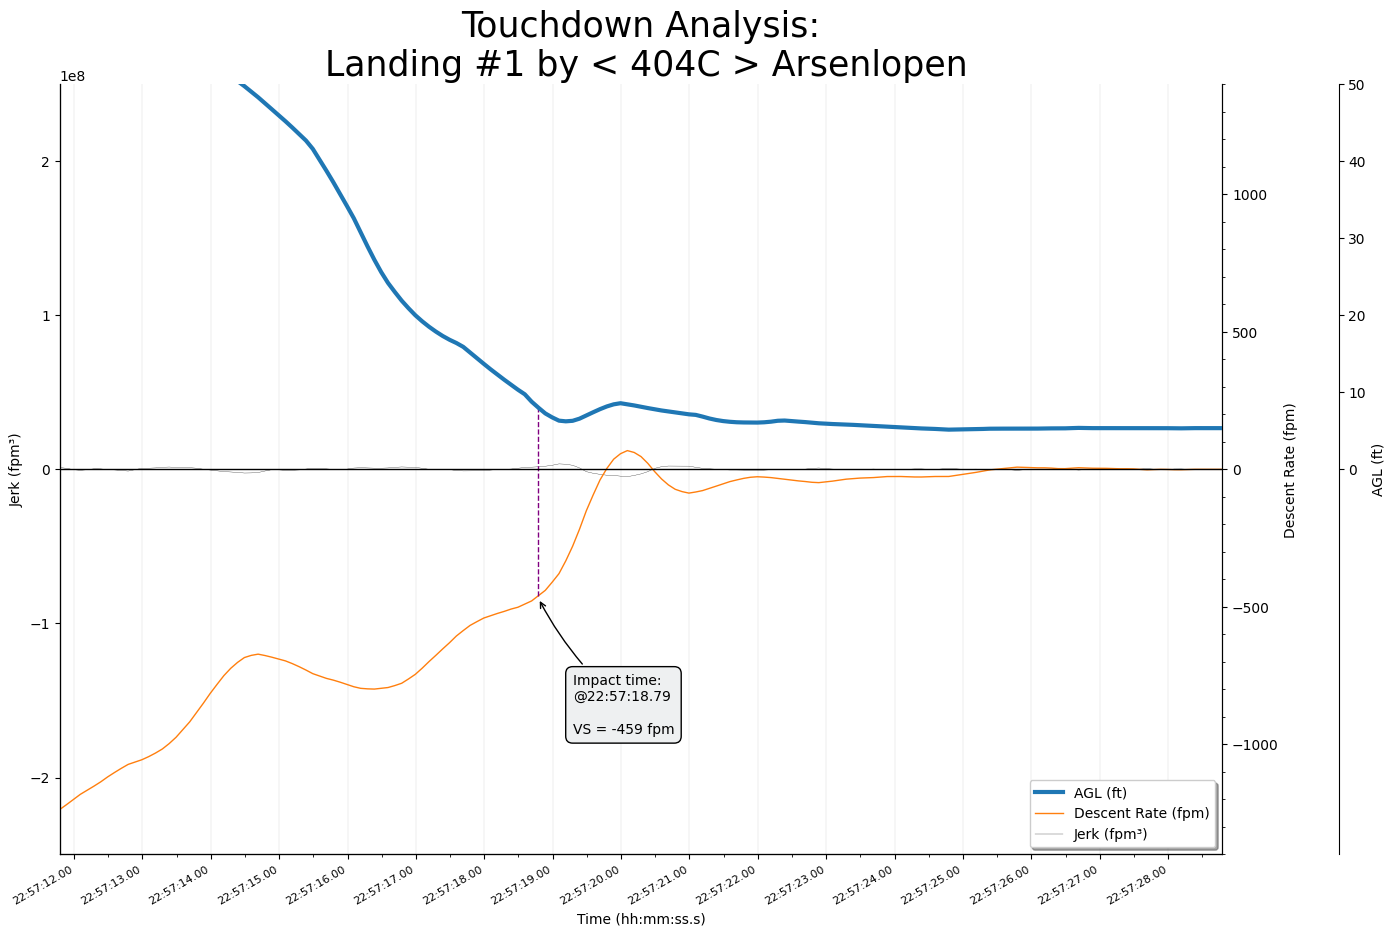

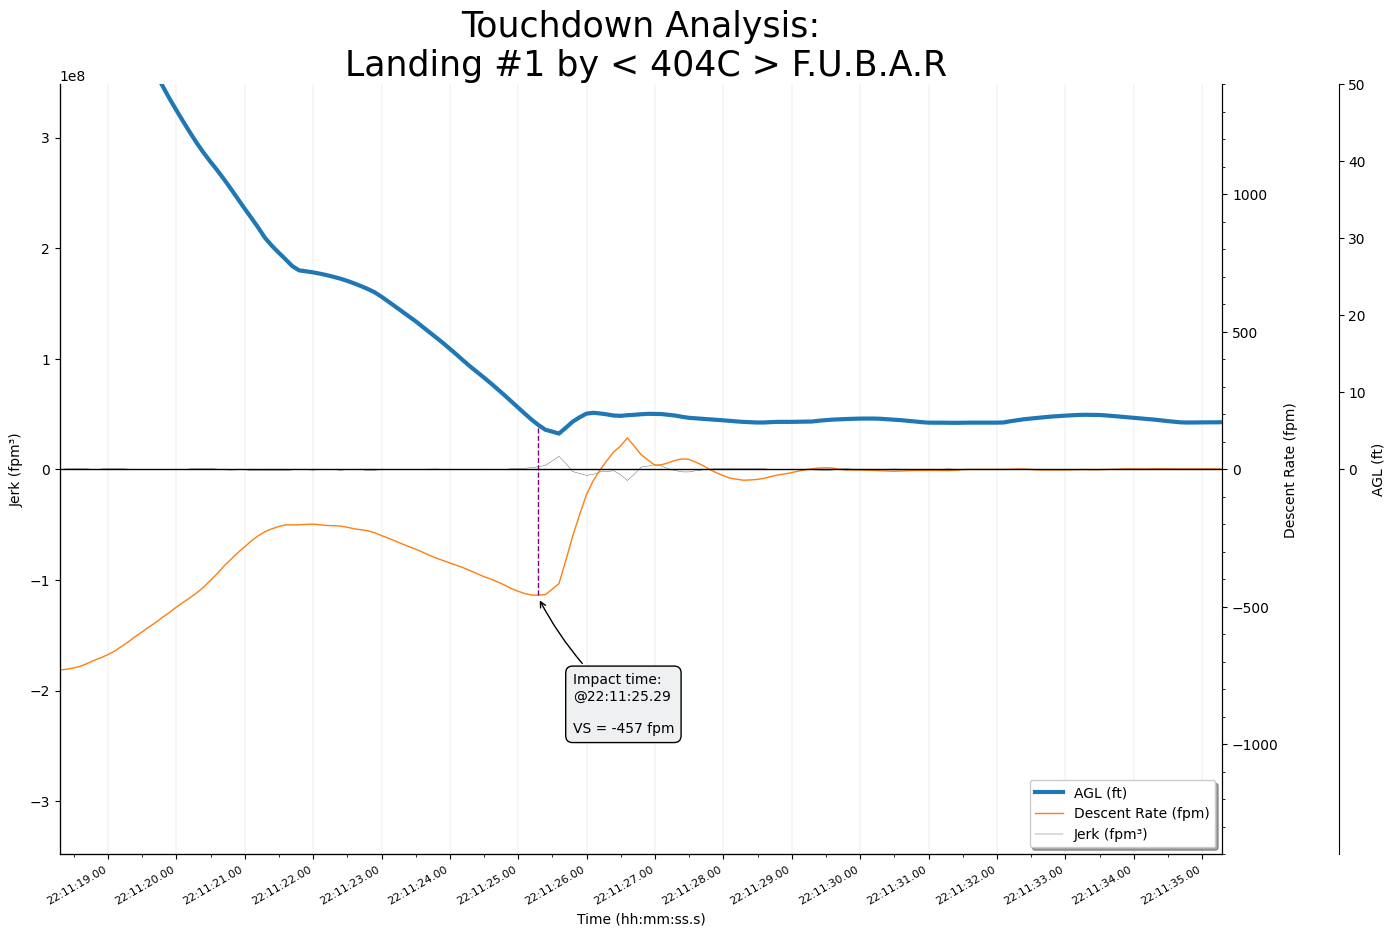

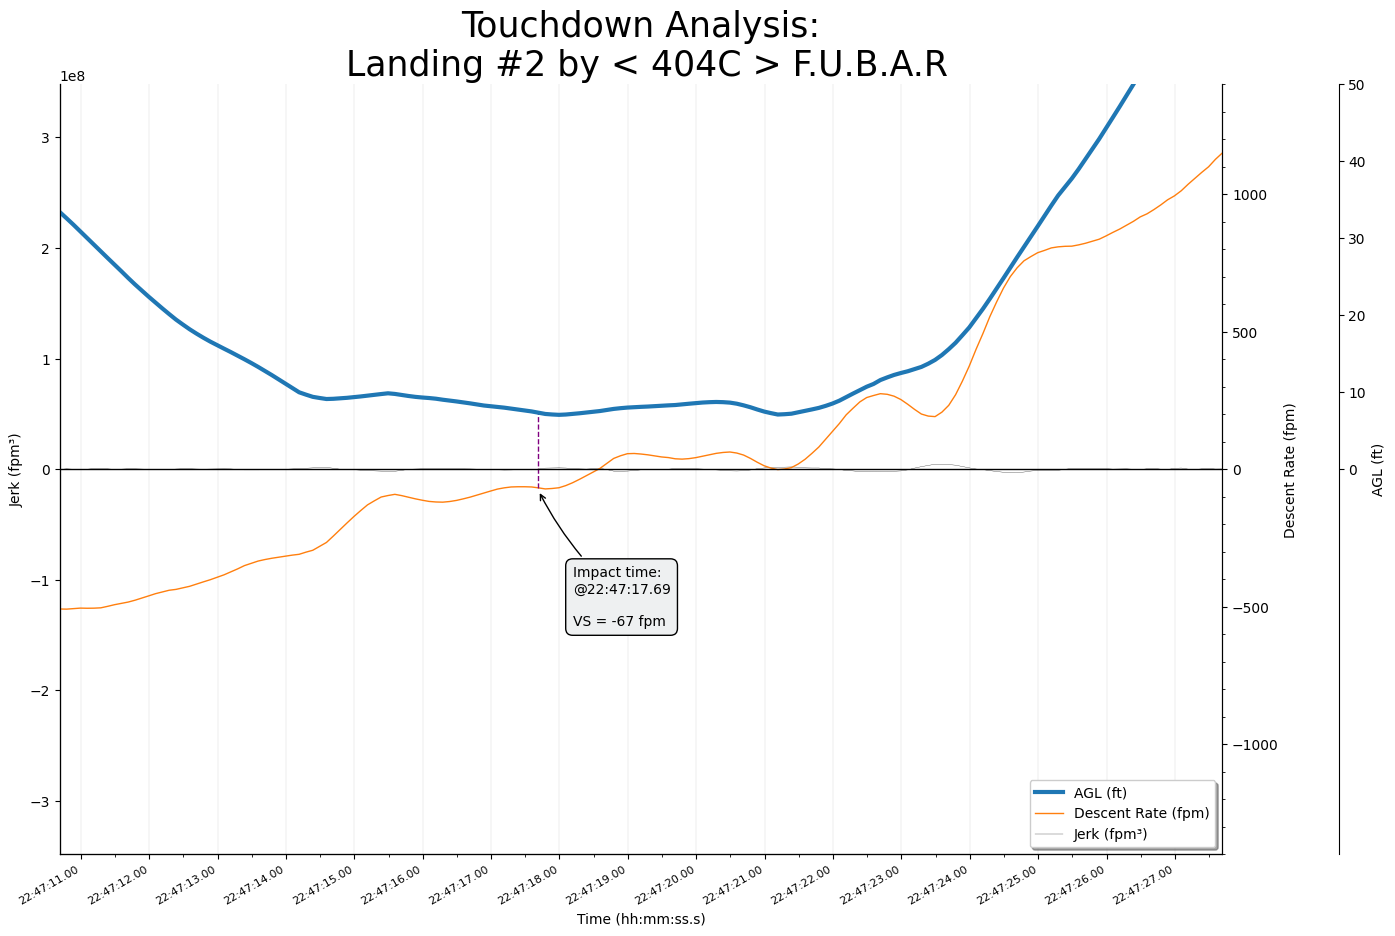

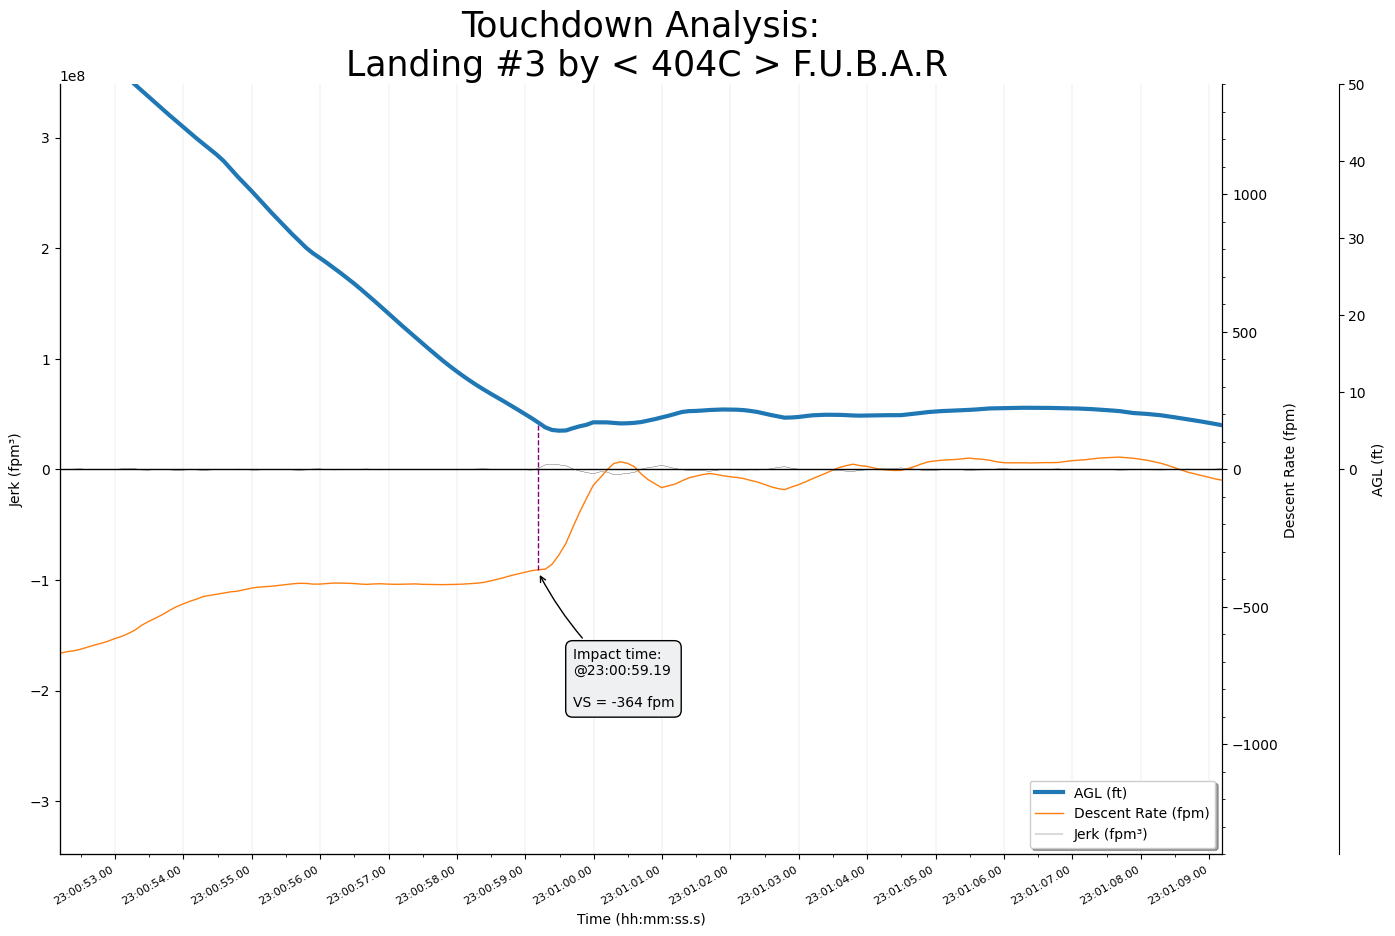

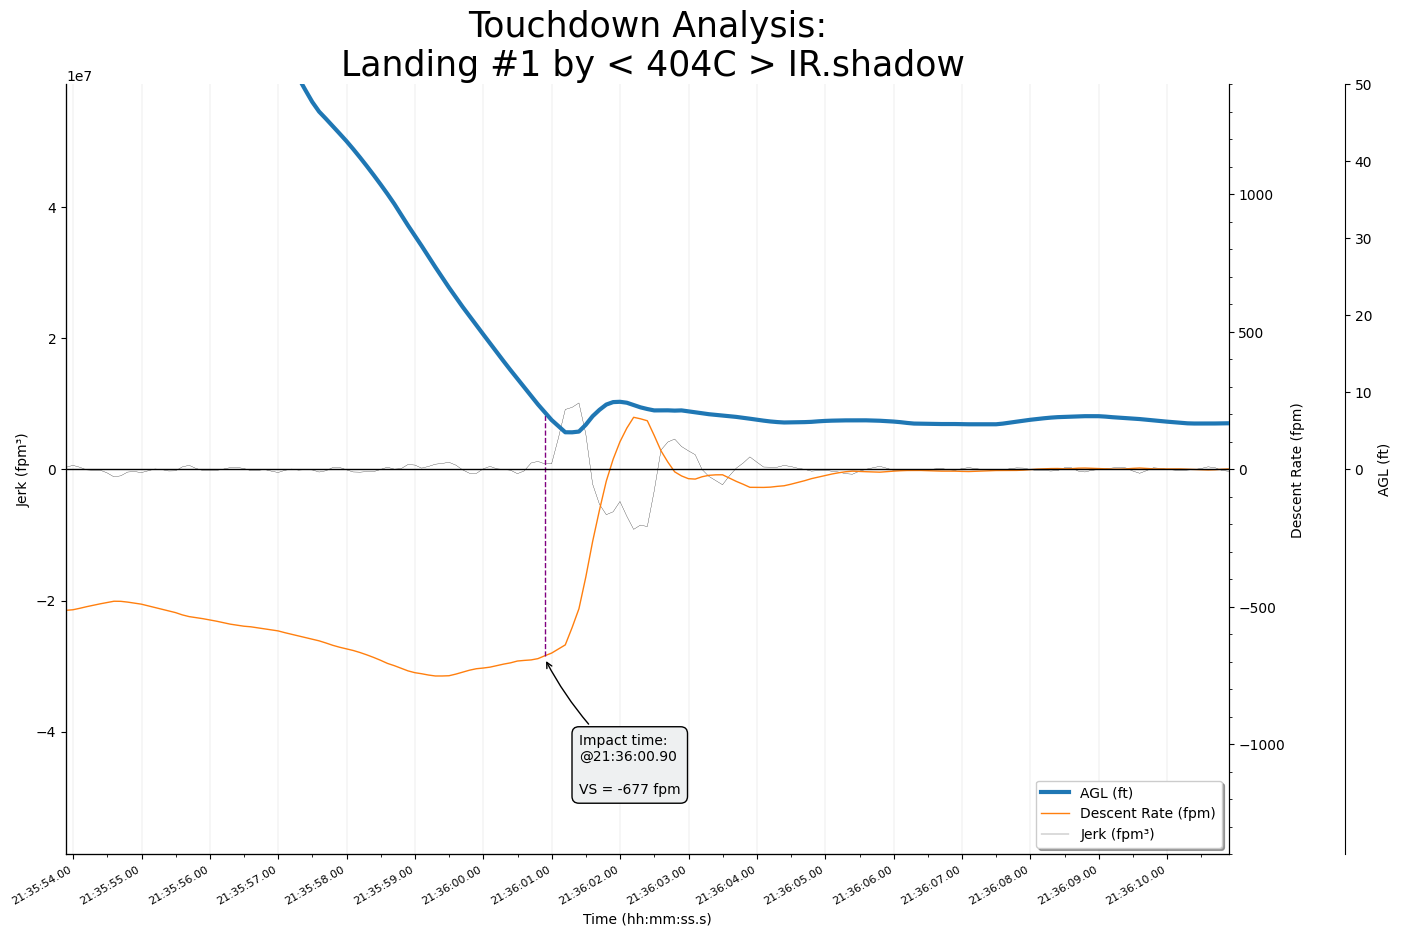

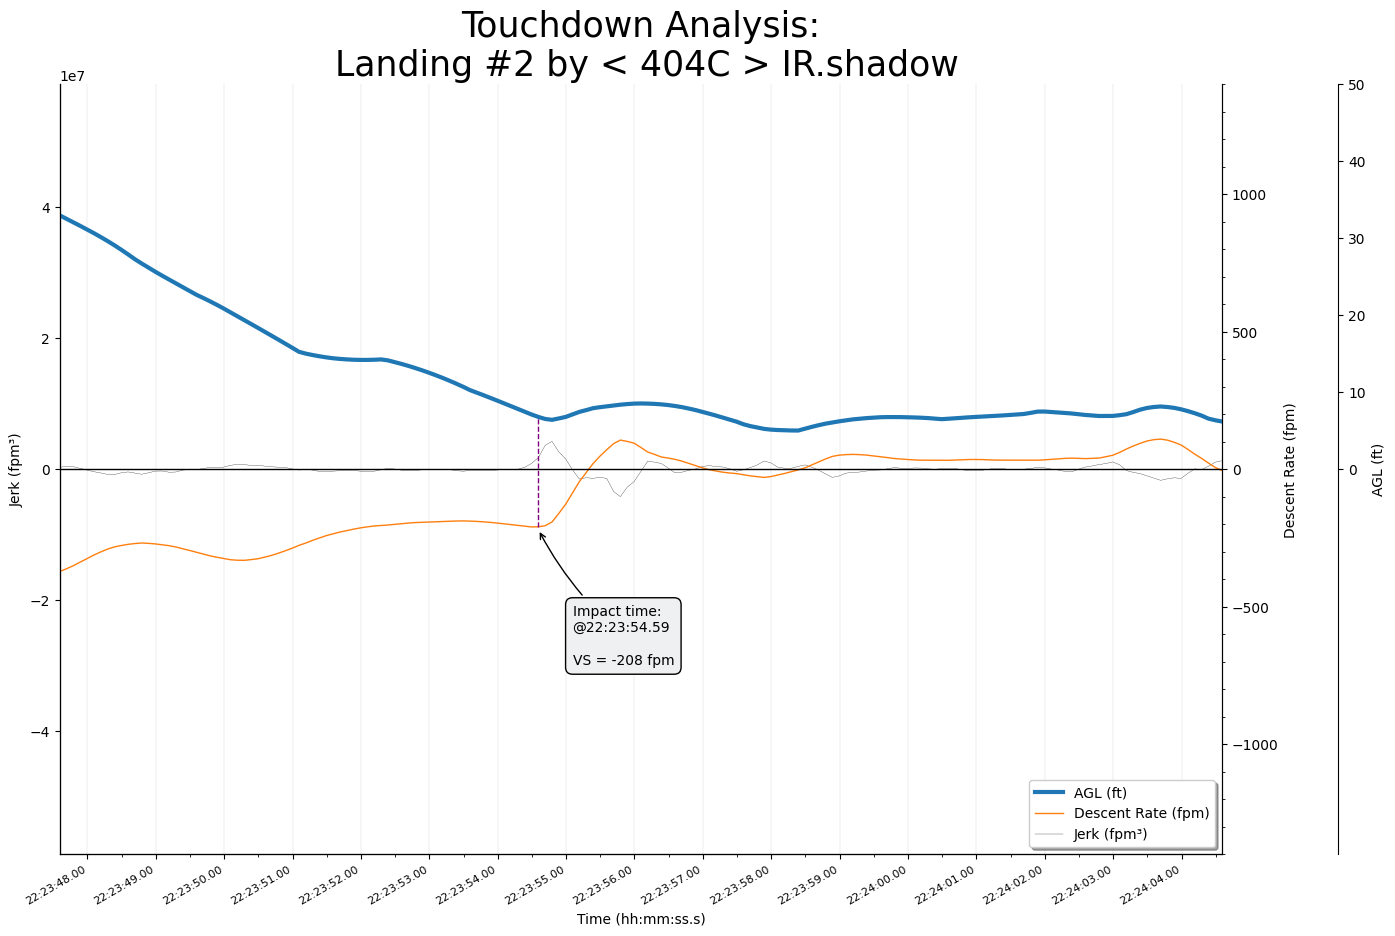

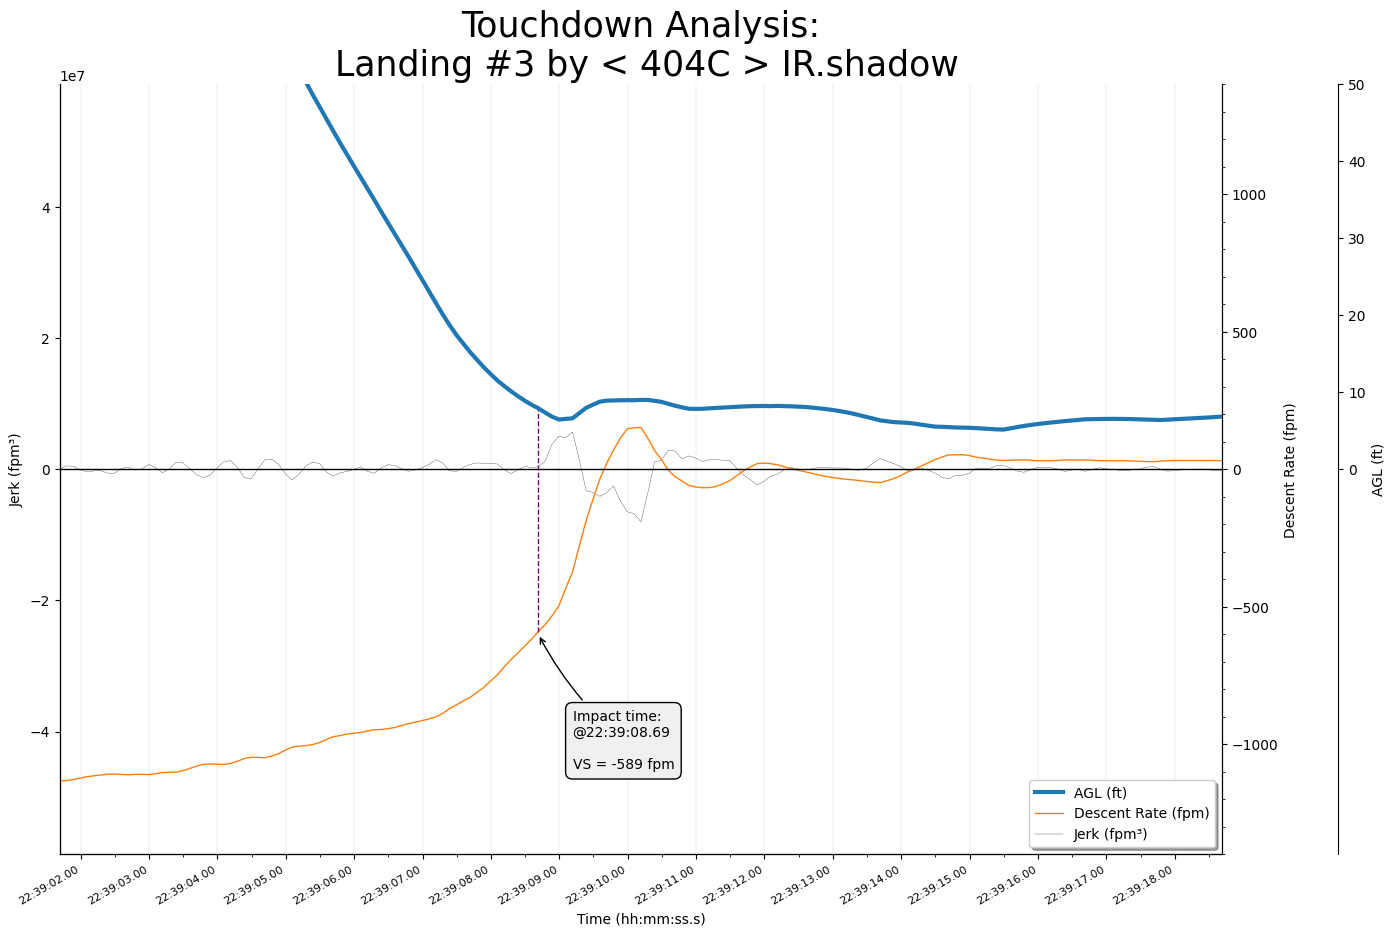

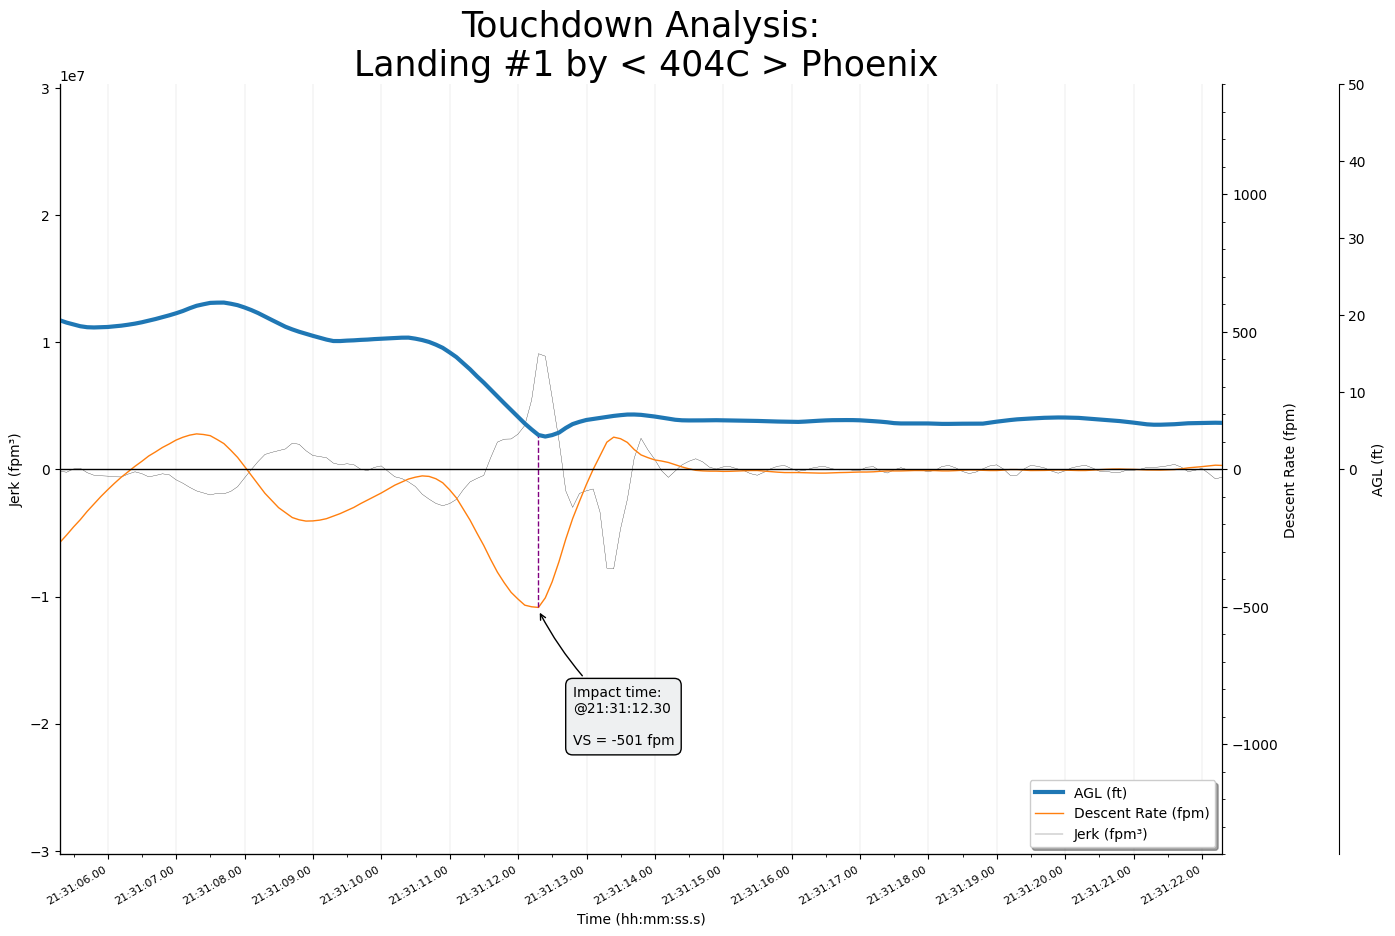

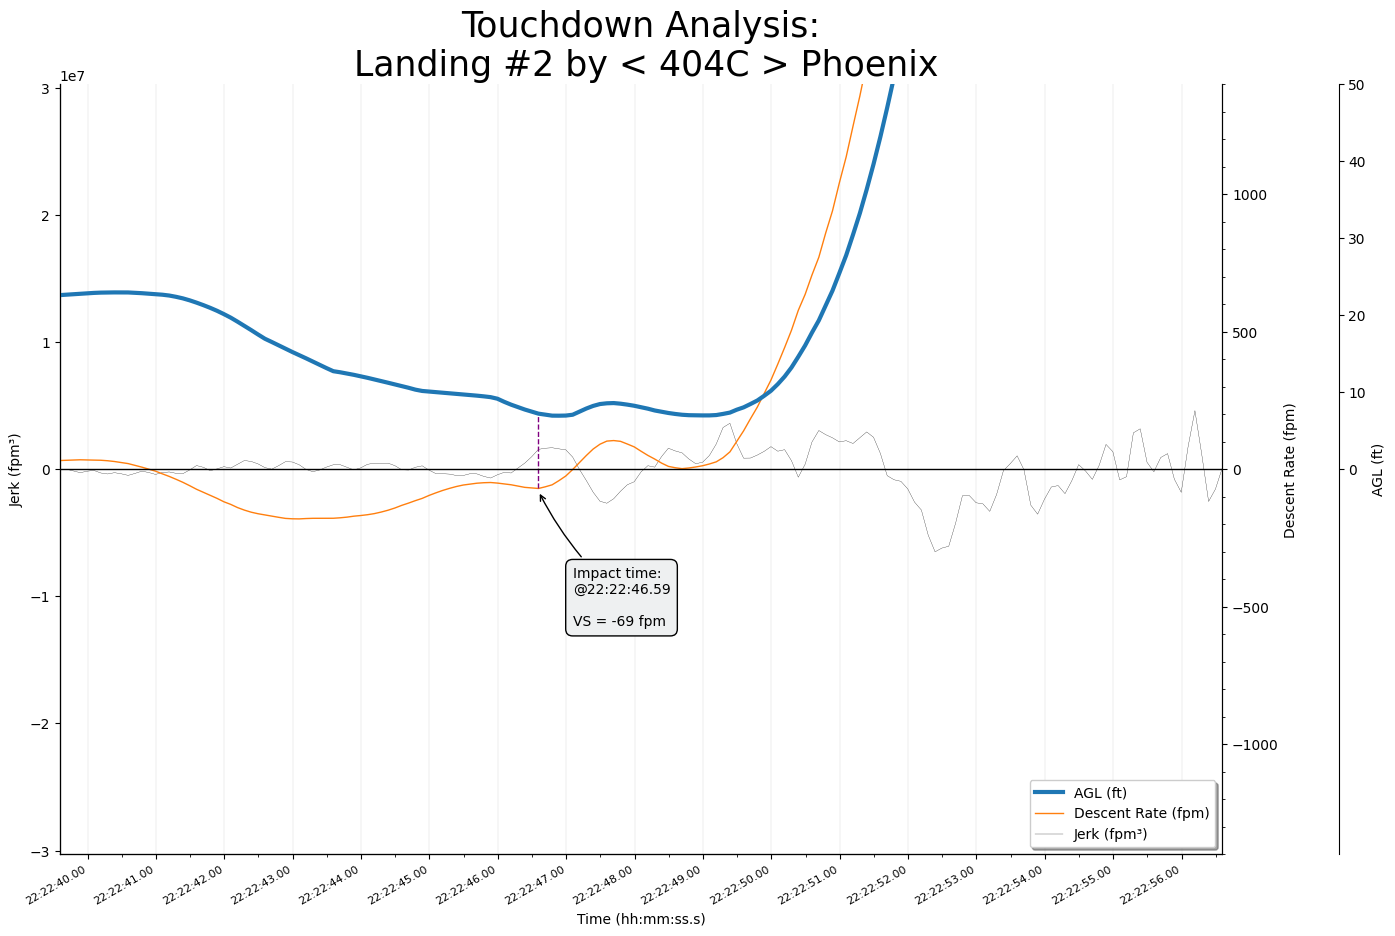

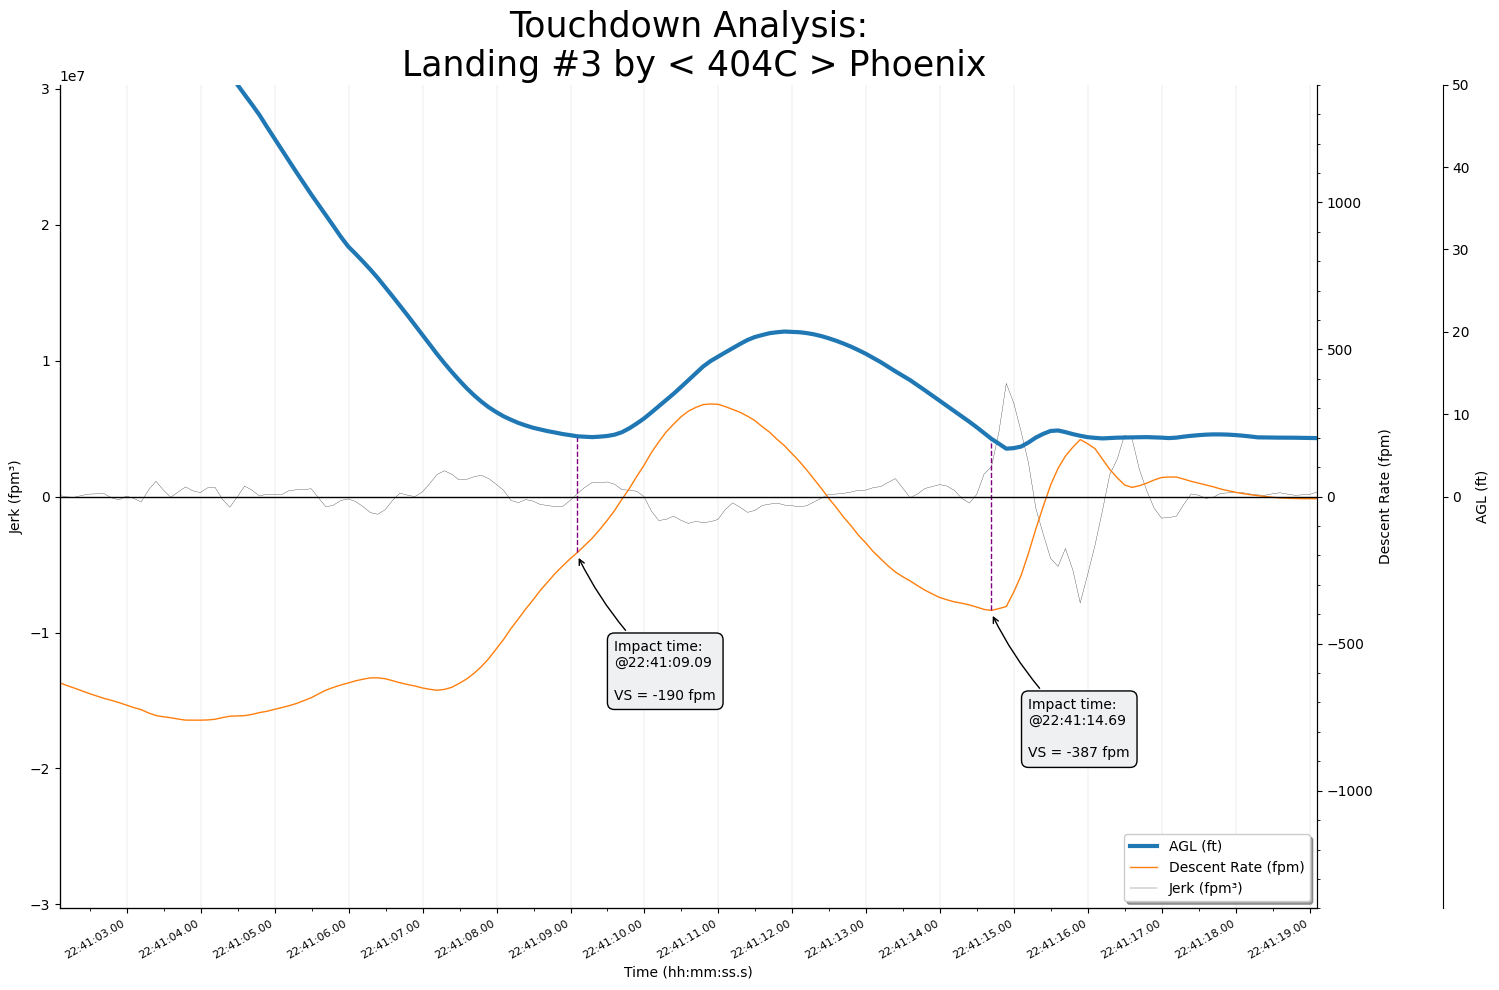

In [134]:
##################################################################
################### TOUCHDOWN PLOTTER FUNCTION ###################

def touchdown_plotter(pilot, sortie_num):

    # Break if current touchdown is less than 5 second the previous one
    current_touchdown  = df_result.loc[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num    ), 'td_timestamp_seconds']
    previous_touchdown = df_result.loc[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num - 1), 'td_timestamp_seconds']
    next_touchdown     = df_result.loc[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num + 1), 'td_timestamp_seconds']
    
    # If there's no previous touchdown, we can't compare
    if not current_touchdown.empty and not previous_touchdown.empty:
        if current_touchdown.iloc[0] - previous_touchdown.iloc[0] < 10:
            print(f'Sortie #{sortie_num} of {pilot} Took less than 5 second!')
            return

    # Filter to Pilot
    df_plot = df_sub[df_sub['Pilot'] == pilot]

    # time_window & next touchdown
    touch_moment  = df_result[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num)]   ['td_timestamp_seconds'].iloc[0]
    if df_result[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num+1)] ['td_timestamp_seconds'].shape[0] > 0:
        touch_moment2 = df_result[(df_result['Pilot'] == pilot) & (df_result['sortie_num'] == sortie_num+1)] ['td_timestamp_seconds'].iloc[0]
    else:
        touch_moment2 = False

    time_window = (touch_moment-7, touch_moment+10)

    # Manual time_window
    # time_window = dt.timedelta(hours=3, minutes=26, seconds= 12).total_seconds(), dt.timedelta(hours=3, minutes=26, seconds= 20).total_seconds()

    #################### Jerk plot ##################

    fig, ax1= plt.subplots(figsize=(15, 10))

    sns.lineplot(data=df_plot, x='timestamp_seconds', y='vert_Jerk_fpm3', ax=ax1, 
                color='k', linewidth=0.2, label='Jerk (fpm³)')

    ax1_ylim = max(abs(ax1.get_ylim()[0]), abs(ax1.get_ylim()[1]))
    ax1.set_ylim(-ax1_ylim, ax1_ylim)

    # SPINE POSITION
    # offset_text = ax1.yaxis.get_offset_text()
    # offset_text.set_x(-0.20) # Adjust this value for perfect alignment
    # offset_text.set_horizontalalignment('left')

    # X-AXIS FORMATTING
    plt.xlim(time_window)

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_seconds))
    major_locator = ticker.MultipleLocator(1)   # Major ticks every ? seconds
    minor_locator = ticker.MultipleLocator(0.5)  # Minor ticks every ? second
    ax1.xaxis.set_major_locator(major_locator)
    ax1.xaxis.set_minor_locator(minor_locator)

    for label in ax1.get_xticklabels():
        label.set(rotation=30, horizontalalignment='right', fontsize= 8)

    # Y-AXIS FORMATTING
    # plt.ylim(-0.8e5, 0.8e5)
    formatter = ticker.ScalarFormatter(useMathText=False)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax1.yaxis.set_major_formatter(formatter)

    # #################### Vertical Acceleration plot ##################
    # ax2 = ax1.twinx()    
    # sns.lineplot(data=df_plot, x='timestamp_seconds', y='vert_Acc_fpm2', ax=ax2, 
    #             color='blue', linewidth=0.1, label='Vertical Acceleration (fpm²)')

    #################### Vertical Speed plot ##################
    ax2 = ax1.twinx()
    sns.lineplot(data=df_plot, x='timestamp_seconds', y='VS', ax=ax2, 
                color='tab:orange', linewidth=1, label='Descent Rate (fpm)')

    ax2.set_ylim(-1400, 1400)   
    ax2.set_yticks(np.arange(-1400, 1500, 100), minor=True)

    #################### AGL plot ##################
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("axes", 1.1))

    sns.lineplot(data=df_plot, x='timestamp_seconds', y='AGL', ax=ax3, 
                color='tab:blue', linewidth=3, label='AGL (ft)')

    ax3.set_ylim(-50, 50)
    ax3.set_yticks(np.arange(0, 51, 10), minor=False)

    ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)

    # DESPINE
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['top'].set_visible(False)

    # GRIDLINES
    ax1.grid(axis='x', which='major', linestyle='-', linewidth='0.1', color='gray')
    # ax1.grid(axis='x', which='minor', linestyle=':', linewidth='0.5', color='gray')             
    # ax4.grid(axis='y', which='major', linestyle='-', linewidth='0.5', color='gray') 
    # ax4.grid(axis='y', which='minor', linestyle=':', linewidth='0.5', color='gray') 

    # TITLES
    plt.title(f'Touchdown Analysis:\n Landing #{sortie_num} by {pilot}', fontsize=25)
    ax1.set_xlabel('Time (hh:mm:ss.s)')
    ax1.set_ylabel('Jerk (fpm³)')    
    ax2.set_ylabel('Descent Rate (fpm)')
    ax3.set_ylabel('AGL (ft)')
    # ax1.set_ylabel('Vertical Acc (fpm²)')

    # LEGENDS
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    ax1.legend(lines3 + lines2 + lines1, labels3 + labels2 + labels1, loc='lower right', shadow=True)

    # ANNOTATE THE IMPACT
    vs_1st  = df_plot[df_plot['timestamp_seconds'] == touch_moment]['VS'] .iloc[0]
    agl_1st = df_plot[df_plot['timestamp_seconds'] == touch_moment]['AGL'].iloc[0]
    ax2.axvline(x=touch_moment , color='purple', linestyle='--', linewidth=1, ymin= (1400+vs_1st)/2800, ymax= (50+agl_1st)/100)
    ax2.annotate(text= 'Impact time: \n@' + format_seconds(touch_moment) + f'\n\nVS = {int(vs_1st)} fpm',
                xy     = (touch_moment    , vs_1st - 10 ), 
                xytext = (touch_moment+0.5, vs_1st - 500),
                arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3, rad=-0.1"),
                bbox=dict(facecolor="#EEF0F1FF", edgecolor='black', boxstyle='round, pad=0.5')
                )
    if touch_moment2:
        vs_2nd  = df_plot[df_plot['timestamp_seconds'] == touch_moment2]['VS'] .iloc[0]
        agl_2nd = df_plot[df_plot['timestamp_seconds'] == touch_moment2]['AGL'].iloc[0]
        ax2.axvline (x=touch_moment2, color='purple', linestyle='--', linewidth=1, ymin= (1400+vs_2nd)/2800, ymax= (50+agl_2nd)/100)
        ax2.annotate(text= 'Impact time: \n@' + format_seconds(touch_moment2) + f'\n\nVS = {int(vs_2nd)} fpm',
                    xy    = (touch_moment2    , vs_2nd - 10 ), 
                    xytext= (touch_moment2+0.5, vs_2nd - 500),
                    arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3, rad=-0.1"),
                    bbox=dict(facecolor="#EEF0F1FF", edgecolor='black', boxstyle='round, pad=0.5')
                    )
    
    # EXPORT PLOTS
    fig.savefig(os.path.join (results_dir+'\\Detailed Touchdowns', 
                              f'[{date_tacview}] {extract_pilot_name(pilot)}_touch_{sortie_num}.png'
                             ), 
                dpi=300, bbox_inches='tight'
                )


##################################################################
################### Creating subplots landings ###################
# touchdown_plotter(pilot= '< 404C > Phoenix', sortie_num= 4)
for pilot in observed_Pilots:
    for sortie in df_result[df_result['Pilot'] == pilot]['sortie_num'].unique():
        touchdown_plotter(pilot, sortie)

plt.style.use('default')
plt.tight_layout()
plt.show()